In [1]:
#import ROOT
import os, re, gc, h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [4]:
datetime.now().strftime("%H:%M:%S")

'19:15:00'

In [2]:
def rem_col_median(X):
    for i, img in enumerate(X):
        for j in range(X.shape[-1]):
            X[i,...,j] -= np.median(np.ravel(img[...,j]))
    xmax = 1 if X.max()<=1 else 255
    return np.clip(X, 0, xmax)

In [3]:
def no_zero_side(imgs):
    return np.any(imgs[:,0,...], axis=(-2,-1))*np.any(imgs[...,0,:], axis=(-2,-1))*np.any(imgs[:,-1,...], axis=(-2,-1))*np.any(imgs[...,-1,:], axis=(-2,-1))
def unblob(X, thr=None):
    ### for col img thr>5/255
    if thr is None:
        thr = 5/255. if (X.shape[-1]==3 or X.shape[-1]==4) else 0.1
    mask = np.ones(X.shape[0], dtype=bool)
    for i, img in enumerate(X):
        if np.any(np.median(img, axis=(0,1))>thr): mask[i] = False
    return mask*no_zero_side(X)

## Image Extraction
* ROOT file extraction with 'data_run.py'

In [4]:
start = datetime.now()
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    with h5py.File('data_scale_ims_col_40.h5','a') as outf:
        #print(df['Carbon/100keV/0degr'].keys())
        for k in ['100','60','30']:
            tmp_dat = np.vstack(tuple([df['Carbon/'+k+'keV/'+d+'/images'][:, 10:-10, 10:-10, :]/255 for d in ['0degr','45degr','90degr']]))#.astype(np.int16)
            mask = unblob(tmp_dat)
            tmp_dat = tmp_dat[:, 10:-10, 10:-10, :]
            #for i in range(tmp_dat.shape[-1]):
            #    tmp_dat[...,i] -= np.median(np.ravel(tmp_dat[...,i]))#.astype(np.int16)
            #tmp_dat = tmp_dat[...]/255
            outf.create_dataset('Carbon/'+k+'keV/images', data=rem_col_median(tmp_dat[mask]) )
            #outf.create_dataset('Carbon/'+k+'keV/images', data=np.vstack(tuple([df['Carbon/'+k+'keV/'+d+'/images'][:, 20:-20, 20:-20, :]/255 for d in ['0degr','45degr','90degr']])) )
            tmp_ids = np.vstack(tuple([df['Carbon/'+k+'keV/'+d+'/pol_ids'][...] for d in ['0degr','45degr','90degr']]))
            outf.create_dataset('Carbon/'+k+'keV/pol_ids', data=tmp_ids[mask])
            del tmp_dat, tmp_ids
            gc.collect()
            print('Carbon',k,'\t\t', np.around((len(mask)-mask.sum())/len(mask)*100,decimals=1),'%', outf['Carbon/'+k+'keV/images'].shape)
            print(datetime.now()-start)
        gc.collect()
        
        tmp_dat = np.vstack(tuple([df['fog/Scan'+str(d)+'/images'][:, 10:-10, 10:-10, :]/255 for d in range(1,17)]))#.astype(np.int16)
        mask = unblob(tmp_dat)
        tmp_dat = tmp_dat[:, 10:-10, 10:-10, :]
        #for i in range(tmp_dat.shape[-1]):
        #    tmp_dat[...,i] -= np.median(np.ravel(tmp_dat[...,i]))#.astype(np.int16)
        #tmp_dat = tmp_dat[...]/255
        outf.create_dataset('fog/images', data=rem_col_median(tmp_dat[mask]) )
        #outf.create_dataset('fog/images', data=np.vstack(tuple([df['fog/Scan'+str(d)+'/images'][:, 20:-20, 20:-20, :]/255 for d in range(1,17)])) )
        tmp_ids = np.vstack(tuple([df['fog/Scan'+str(d)+'/pol_ids'][...] for d in range(1,17)]))
        outf.create_dataset('fog/pol_ids', data=tmp_ids[mask])
        print('fog','\t\t', np.around((len(mask)-mask.sum())/len(mask)*100,decimals=1),'%',outf['fog/images'].shape)
        print(datetime.now()-start)
        del tmp_dat, tmp_ids
        gc.collect()

Carbon 100 		 5.3 % (77858, 40, 40, 4)
0:01:12.310966
Carbon 60 		 2.8 % (75583, 40, 40, 4)
0:02:44.027537
Carbon 30 		 4.1 % (48802, 40, 40, 4)
0:03:20.075535
fog 		 12.0 % (46994, 40, 40, 4)
0:04:24.755819


In [5]:
len(mask)

53409

In [6]:
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    for k in ['100','60','30']:
        for c in range(4):
            print(k, c, '\t', np.median(np.ravel(df['Carbon/'+k+'keV/images'][...,c])), np.min(np.ravel(df['Carbon/'+k+'keV/images'][...,c])))

100 0 	 0.0 0.0
100 1 	 0.0 0.0
100 2 	 0.0 0.0
100 3 	 0.0 0.0
60 0 	 0.0 0.0
60 1 	 0.0 0.0
60 2 	 0.0 0.0
60 3 	 0.0 0.0
30 0 	 0.0 0.0
30 1 	 0.0 0.0
30 2 	 0.0 0.0
30 3 	 0.0 0.0


In [7]:
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    print(df['Carbon/100keV'].keys())

<KeysViewHDF5 ['0degr', '45degr', '90degr', 'test']>


In [20]:
cl_names = ['Carbon/30keV','Carbon/60keV','Carbon/100keV','fog']#'gamma'
label_dict = {'Carbon/30keV':0, 'Carbon/60keV':1, 'Carbon/100keV':2, 'fog':3} #'gamma'
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    X_tr, X_val = np.ones((0,40,40,4), dtype=np.float32), np.ones((0,40,40,4), dtype=np.float32)
    y_tr, y_val = [], []
    for name in cl_names:
        val = 9500 if not 'keV' in name else 7000
        tr = 37300 if not 'keV' in name else 25000
        N_load = tr+val
        X_tmp = df[name+'/images'][:N_load]
        X_tr_tmp, X_val_tmp = train_test_split(X_tmp, test_size=val)
        X_tr = np.vstack((X_tr, X_tr_tmp))
        y_tr = np.append(y_tr, np.ones(tr)*label_dict[name])
        X_val = np.vstack((X_val, X_val_tmp))
        y_val = np.append(y_val, np.ones(val)*label_dict[name])
        gc.collect()
del X_tmp, X_tr_tmp, X_val_tmp; gc.collect()
shuf_tr, shuf_val = np.random.permutation(len(y_tr)), np.random.permutation(len(y_val))
with h5py.File('data_ready_'+str(len(cl_names))+'.h5','a') as outf:
    outf.create_dataset('train/images', data=X_tr[shuf_tr])
    outf.create_dataset('train/labels', data=y_tr[shuf_tr])
    outf.create_dataset('val/images', data=X_val[shuf_val])
    outf.create_dataset('val/labels', data=y_val[shuf_val])

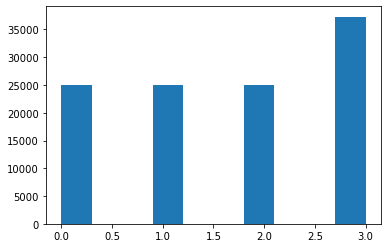

In [21]:
with h5py.File('data_ready_'+str(len(cl_names))+'.h5','r') as df:
    plt.hist(df['train/labels'])

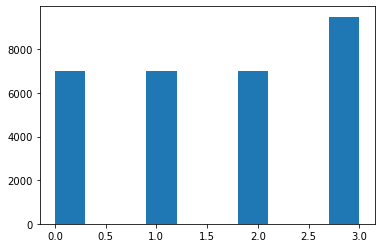

In [22]:
with h5py.File('data_ready_'+str(len(cl_names))+'.h5','r') as df:
    plt.hist(df['val/labels'])

## Direction study data

In [11]:
start = datetime.now()
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    with h5py.File('data_direction.h5','a') as outf:
        #print(df['Carbon/100keV/0degr'].keys())
        tmp_dat = np.vstack(tuple([df['Carbon/'+k+'keV/0degr/images'][:, 10:-10, 10:-10, :]/255 for k in ['100','60']]))#.astype(np.int16)
        mask = unblob(tmp_dat)
        tmp_dat = tmp_dat[:, 10:-10, 10:-10, :]
        #for i in range(tmp_dat.shape[-1]):
        #    tmp_dat[...,i] -= np.median(np.ravel(tmp_dat[...,i]))#.astype(np.int16)
        #tmp_dat = tmp_dat[...]/255
        tmp_tr, tmp_val = train_test_split(rem_col_median(tmp_dat[mask]), test_size=0.2)
        outf.create_dataset('train/images', data=tmp_tr )
        outf.create_dataset('val/images', data=tmp_val )
        outf.create_dataset('train/labels', data=np.ones(tmp_tr.shape[0], dtype=np.int) )
        outf.create_dataset('val/labels', data=np.ones(tmp_tr.shape[0], dtype=np.int) )
        
        tmp_dat = np.vstack(tuple([df['Carbon/'+k+'keV/test/images'][:, 10:-10, 10:-10, :]/255 for k in ['100','60']]))#.astype(np.int16)
        mask = unblob(tmp_dat)
        tmp_dat = tmp_dat[:, 10:-10, 10:-10, :]
        tmp_dat = rem_col_median(tmp_dat[mask])
        outf.create_dataset('test/images', data=tmp_dat)
        outf.create_dataset('test/labels', data=np.ones(tmp_dat.shape[0], dtype=np.int) )
        
        del tmp_dat, tmp_tr, tmp_val
        gc.collect()
        print(datetime.now()-start)

0:03:13.065800


In [12]:
with h5py.File('data_direction.h5','r') as df:
    print(df['train/images'].shape)
    print(df['val/images'].shape)
    print(df['test/images'].shape)

(41174, 40, 40, 4)
(10294, 40, 40, 4)
(73002, 40, 40, 4)


## Test data

In [23]:
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    print(df['fog'].keys())

<KeysViewHDF5 ['Scan1', 'Scan10', 'Scan11', 'Scan12', 'Scan13', 'Scan14', 'Scan15', 'Scan16', 'Scan17', 'Scan19', 'Scan2', 'Scan21', 'Scan22', 'Scan23', 'Scan3', 'Scan4', 'Scan5', 'Scan6', 'Scan7', 'Scan8', 'Scan9']>


In [24]:
start = datetime.now()
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    with h5py.File('data_scale_ims_col_40.h5','a') as outf:
        #print(df['Carbon/100keV/0degr'].keys())
        for k in ['100','60','30']:
            tmp_dat = df['Carbon/'+k+'keV/test/images'][:, 10:-10, 10:-10, :]/255 #.astype(np.int16)
            mask = unblob(tmp_dat)
            tmp_dat = tmp_dat[:, 10:-10, 10:-10, :]
            #for i in range(tmp_dat.shape[-1]):
            #    tmp_dat[...,i] -= np.median(np.ravel(tmp_dat[...,i]))#.astype(np.int16)
            #tmp_dat = tmp_dat[...]/255
            outf.create_dataset('test/Carbon/'+k+'keV/images', data=rem_col_median(tmp_dat[mask]) )
            #outf.create_dataset('test/Carbon/'+k+'keV/images', data=df['Carbon/'+k+'keV/test/images'][:, 20:-20, 20:-20, :]/255)
            tmp_ids = df['Carbon/'+k+'keV/test/pol_ids'][...]
            outf.create_dataset('test/Carbon/'+k+'keV/pol_ids', data=tmp_ids[mask])
            gc.collect()
            print('Carbon',k,'\t\t', np.around((len(mask)-mask.sum())/len(mask)*100,decimals=1),'%', outf['test/Carbon/'+k+'keV/images'].shape)
            del tmp_dat, tmp_ids; gc.collect()
        gc.collect()
        
        tmp_dat = np.vstack(tuple([df['fog/Scan'+str(d)+'/images'][:, 10:-10, 10:-10, :]/255 for d in [17,19,21,22,23]]))#.astype(np.int16)
        mask = unblob(tmp_dat)
        tmp_dat = tmp_dat[:, 10:-10, 10:-10, :]
        #for i in range(tmp_dat.shape[-1]):
        #    tmp_dat[...,i] -= np.median(np.ravel(tmp_dat[...,i]))#.astype(np.int16)
        #tmp_dat = tmp_dat[...]/255
        outf.create_dataset('test/fog/images', data=rem_col_median(tmp_dat[mask]) )
        #outf.create_dataset('test/fog/images', data=np.vstack(tuple([df['fog/Scan'+str(d)+'/images'][:, 20:-20, 20:-20, :]/255 for d in [17,19,21,22,23]])) )
        tmp_ids = np.vstack(tuple([df['fog/Scan'+str(d)+'/pol_ids'][...] for d in [17,19,21,22,23]]))
        outf.create_dataset('test/fog/pol_ids', data=tmp_ids[mask])
        print('fog','\t\t\t', np.around((len(mask)-mask.sum())/len(mask)*100,decimals=1),'%', outf['test/fog/images'].shape)
        del tmp_dat, tmp_ids; gc.collect()
print(datetime.now()-start)

Carbon 100 		 6.2 % (25479, 40, 40, 4)
Carbon 60 		 2.5 % (44794, 40, 40, 4)
Carbon 30 		 4.2 % (27565, 40, 40, 4)
fog 			 12.8 % (21287, 40, 40, 4)
0:02:28.037923


In [25]:
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    for k in ['100','60','30']:
        for c in range(4):
            print(k, c, '\t', np.median(np.ravel(df['test/Carbon/'+k+'keV/images'][...,c])), np.around(np.min(np.ravel(df['test/Carbon/'+k+'keV/images'][...,c])), decimals=3), np.around(np.std(np.ravel(df['test/Carbon/'+k+'keV/images'][...,c])), decimals=3))
    for c in range(4):
        print('fog', c, '\t', np.median(np.ravel(df['test/fog/images'][...,c])), np.around(np.min(np.ravel(df['test/fog/images'][...,c])), decimals=3), np.around(np.std(np.ravel(df['test/fog/images'][...,c])), decimals=3))


100 0 	 0.0 0.0 0.013
100 1 	 0.0 0.0 0.011
100 2 	 0.0 0.0 0.016
100 3 	 0.0 0.0 0.015
60 0 	 0.0 0.0 0.012
60 1 	 0.0 0.0 0.011
60 2 	 0.0 0.0 0.015
60 3 	 0.0 0.0 0.012
30 0 	 0.0 0.0 0.014
30 1 	 0.0 0.0 0.012
30 2 	 0.0 0.0 0.017
30 3 	 0.0 0.0 0.014
fog 0 	 0.0 0.0 0.022
fog 1 	 0.0 0.0 0.022
fog 2 	 0.0 0.0 0.029
fog 3 	 0.0 0.0 0.017


### Exploring the data

In [14]:
import seaborn as sns
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    X_tmp = df['test/Carbon/60keV/images'][:10000]

In [17]:
copa = np.zeros((X_tmp.shape[0],X_tmp.shape[-1]))
for i in range(X_tmp.shape[0]):
    for j in range(X_tmp.shape[-1]):
        copa[i,j] = np.median(np.ravel(X_tmp[i,...,j]))
for j in range(X_tmp.shape[-1]):
    print((copa[:,j]**2).sum())

4.81482486096809e-35
4.81482486096809e-35
0.0
0.0


In [9]:
import seaborn as sns
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    X_tmp = df['test/fog/images'][:10000]

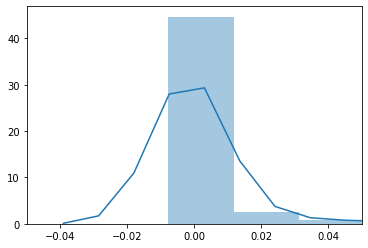

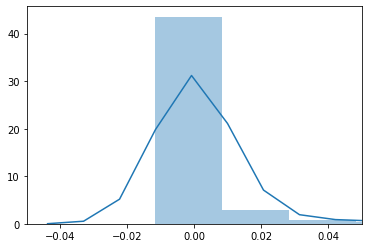

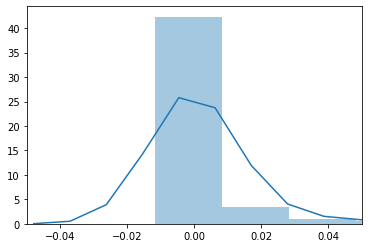

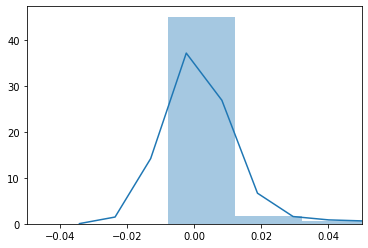

In [10]:
copa = np.zeros((X_tmp.shape[0],X_tmp.shape[-1]))
for i in range(X_tmp.shape[0]):
    for j in range(X_tmp.shape[-1]):
        copa[i,j] = np.median(np.ravel(X_tmp[i,...,j]))
for j in range(X_tmp.shape[-1]):
    sns.distplot(copa[:,j])
    plt.xlim(-0.05,0.05)
    plt.show()

0.0
0.0
0.0
0.0


(-0.1, 0.1)

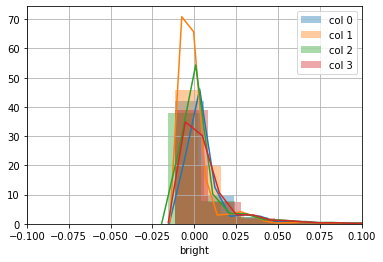

In [12]:
#copa = X_tmp[:1000,...,3].ravel()
for i in range(4):
    sns.distplot(X_tmp[...,i].ravel(), label='col '+str(i))
    print(np.median(X_tmp[...,i].ravel()))
plt.grid()
plt.legend()
plt.xlabel('bright')
plt.xlim(-0.1,0.1)

In [6]:
import seaborn as sns
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    X_tmp = df['test/fog/images'][:1000]

0.011764705882352941
0.011764705882352941
0.011764705882352941
0.00784313725490196


(0, 0.1)

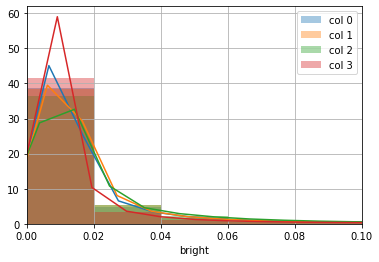

In [7]:
#copa = X_tmp[:1000,...,3].ravel()
for i in range(4):
    sns.distplot(X_tmp[...,i].ravel(), label='col '+str(i))
    print(np.median(X_tmp[...,i].ravel()))
plt.grid()
plt.legend()
plt.xlabel('bright')
plt.xlim(0,0.1)

In [8]:
import seaborn as sns
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    X_tmp = df['test/Carbon/60keV/images'][:1000]

0.00784313725490196
0.00784313725490196
0.011764705882352941
0.00784313725490196


(0, 0.1)

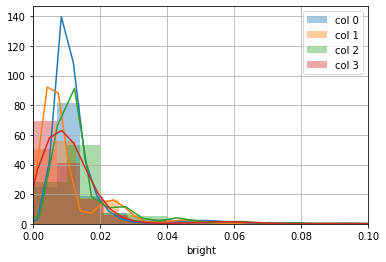

In [9]:
#copa = X_tmp[:1000,...,3].ravel()
for i in range(4):
    sns.distplot(X_tmp[...,i].ravel(), label='col '+str(i))
    print(np.median(X_tmp[...,i].ravel()))
plt.grid()
plt.legend()
plt.xlabel('bright')
plt.xlim(0,0.1)

In [11]:
3/255

0.011764705882352941

0.054901960784313725


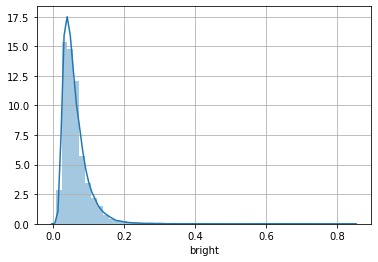

In [21]:
copa = X_tmp[:10000,18:22,18:22,0].ravel()
sns.distplot(copa)
plt.grid()
plt.xlabel('bright')
print(np.median(copa))

In [22]:
import seaborn as sns
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    X_tmp = df['test/fog/images'][...]

0.00784313725490196


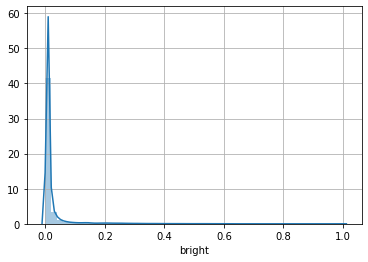

In [23]:
copa = X_tmp[:1000,...,3].ravel()
sns.distplot(copa)
plt.grid()
plt.xlabel('bright')
print(np.median(copa))

0.050980392156862744


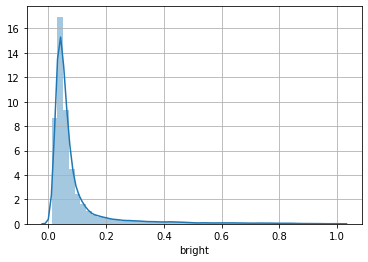

In [24]:
copa = X_tmp[:10000,18:22,18:22,0].ravel()
sns.distplot(copa)
plt.grid()
plt.xlabel('bright')
print(np.median(copa))

In [31]:
255*0.055

14.025

In [4]:
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    tmp_dat = df['Carbon/100keV/0degr/images'][:10000, 10:-10, 10:-10, :]
    bad_im = []
    
    for i, img in enumerate(tmp_dat):
        for j in range(4):
            if np.median(np.ravel(img[...,j]))>25: bad_im.append(i)
print(len(bad_im))

36


In [5]:
with h5py.File('data_raw_root_ims_col_80.h5','r') as df:
    tmp_dat = df['fog/Scan21/images'][:, 10:-10, 10:-10, :]
    bad_im = []
    
    for i, img in enumerate(tmp_dat):
        for j in range(4):
            if np.median(np.ravel(img[...,j]))>25: bad_im.append(i)
print(len(bad_im))

343


In [6]:
tmp_dat.shape

(2081, 60, 60, 4)

In [7]:
len(bad_im)/tmp_dat.shape[0]

0.1648246035559827

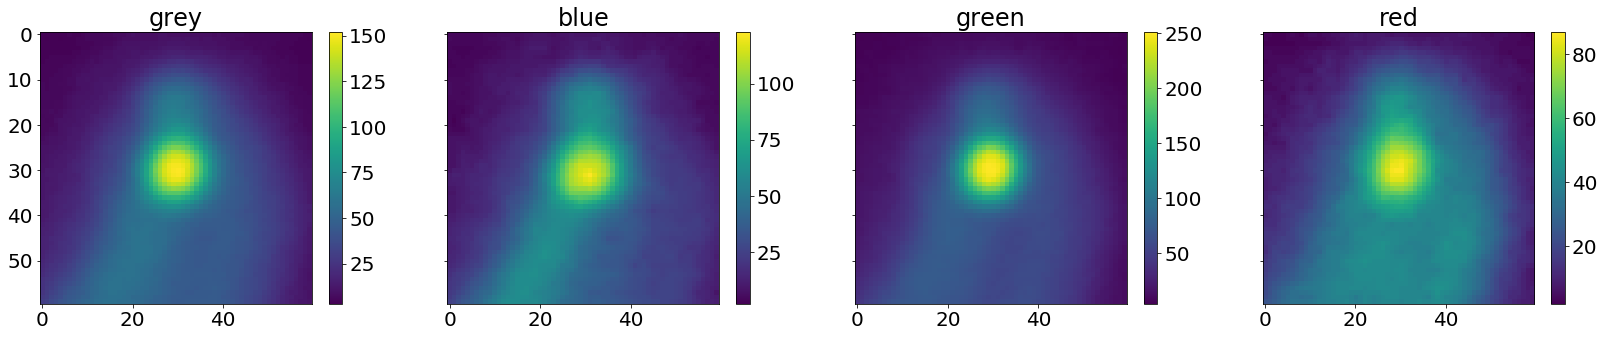

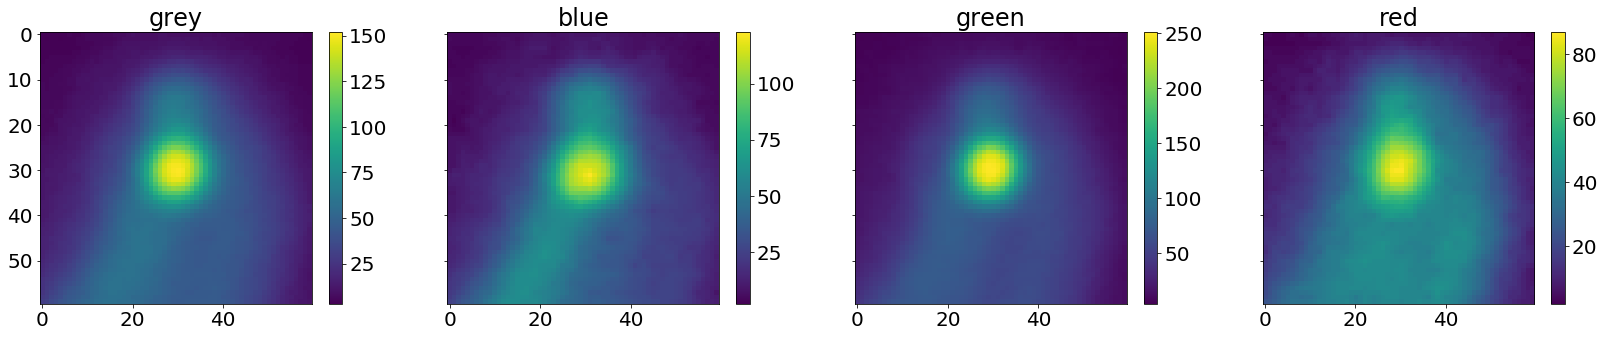

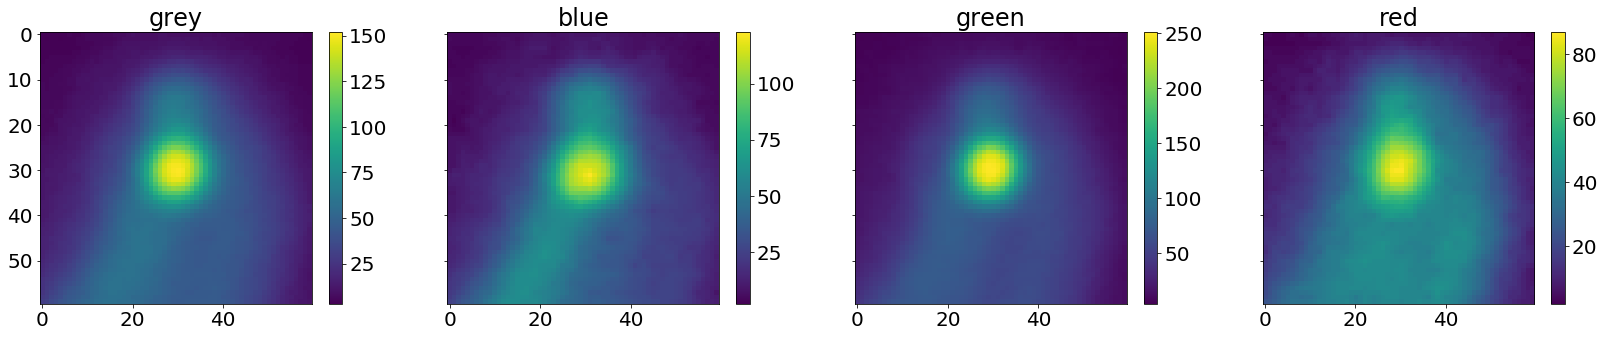

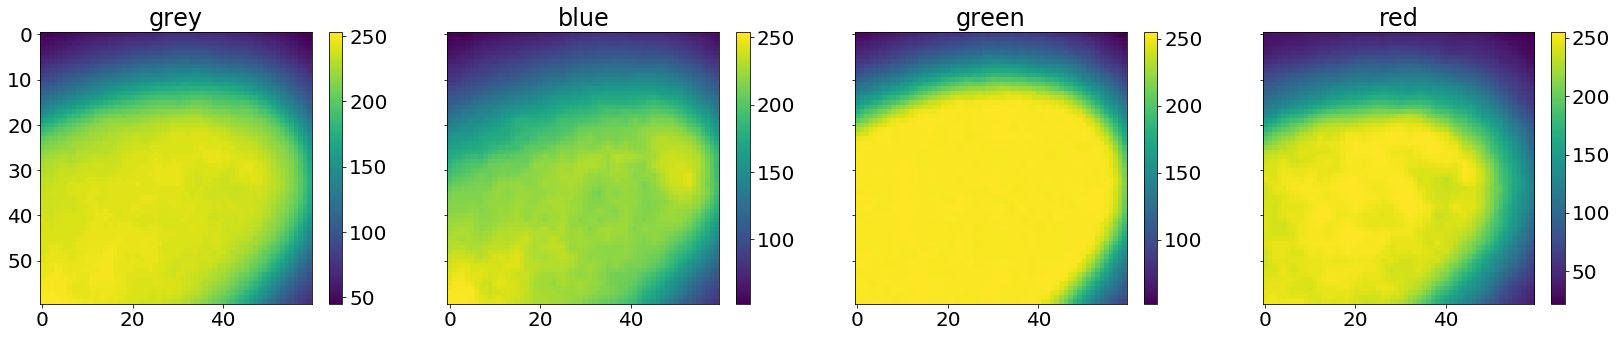

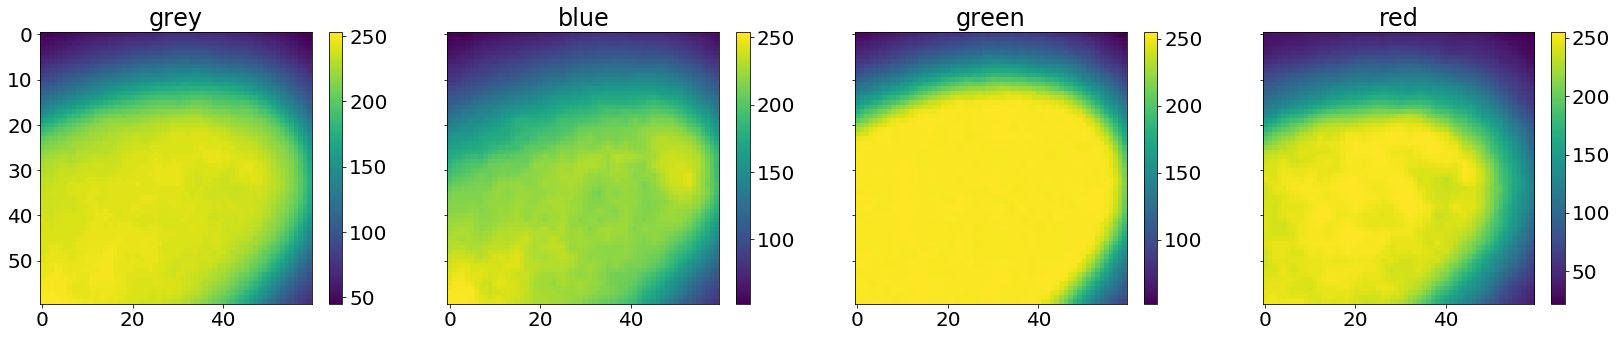

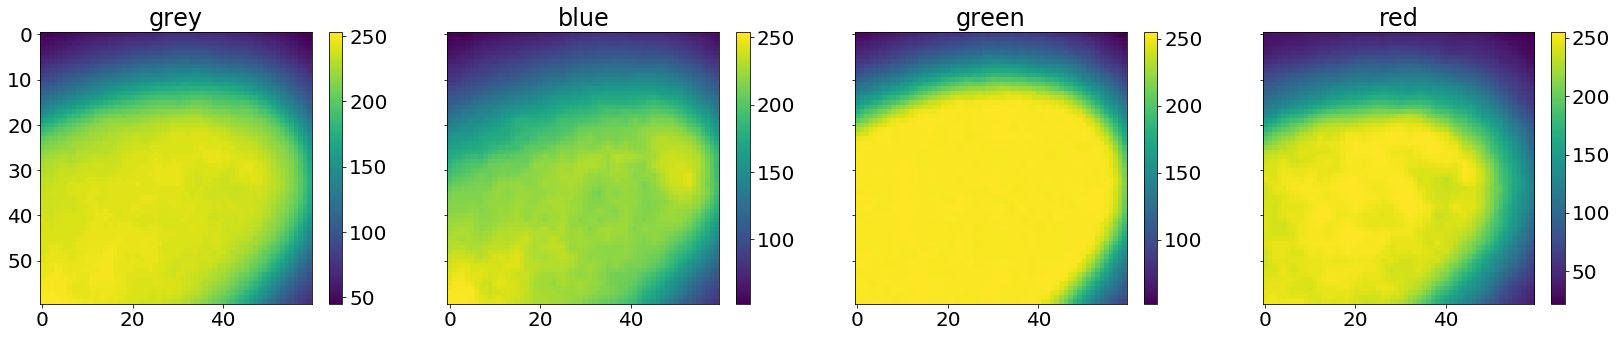

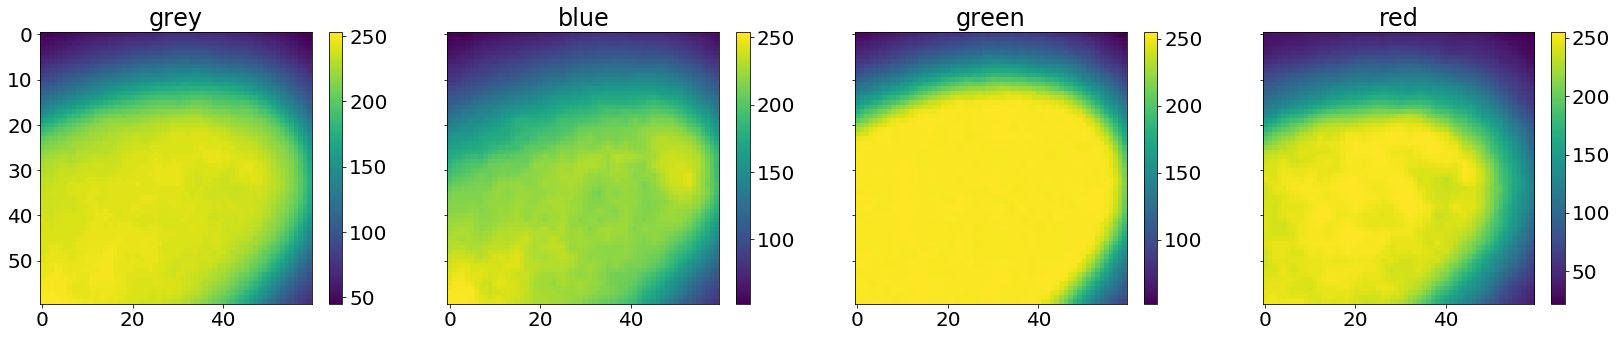

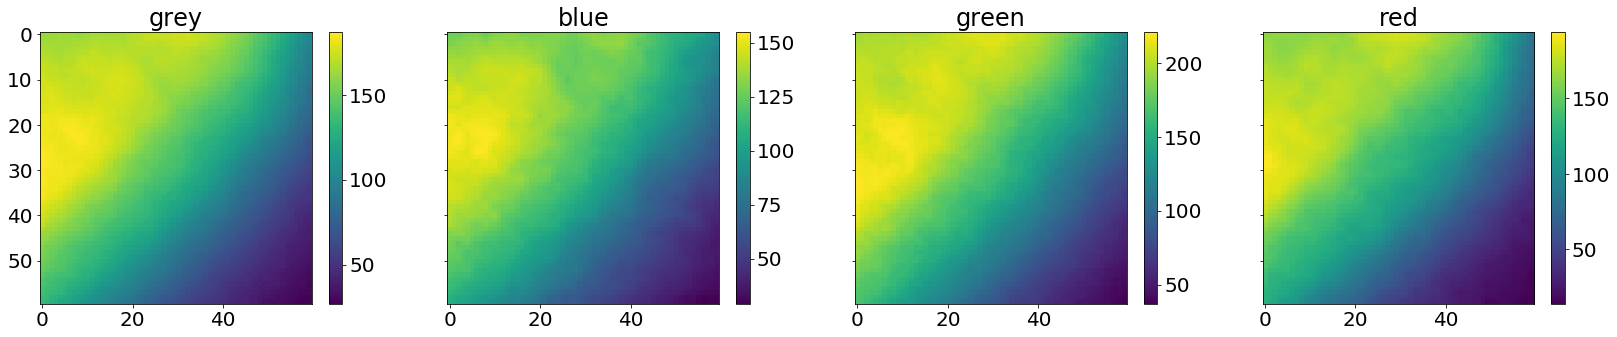

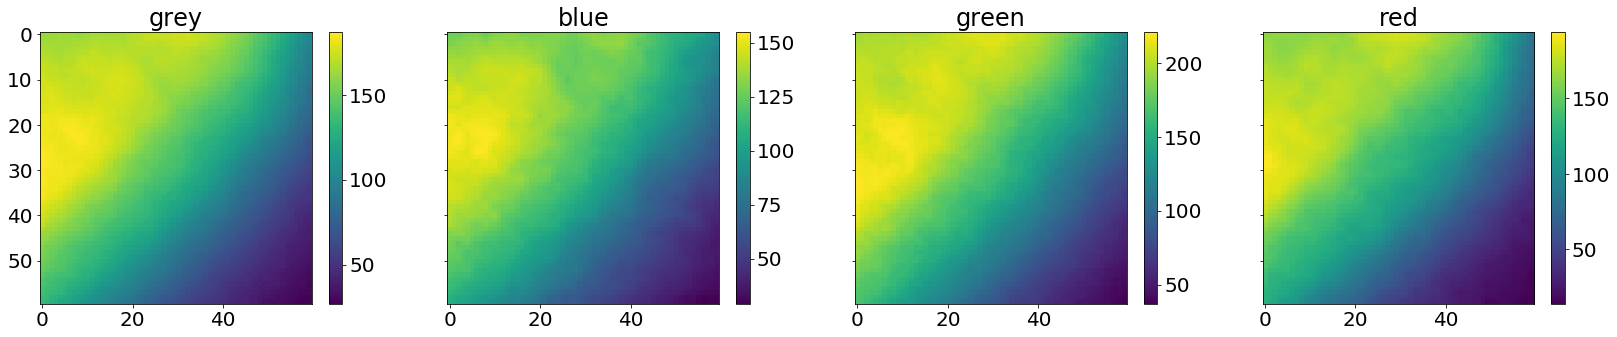

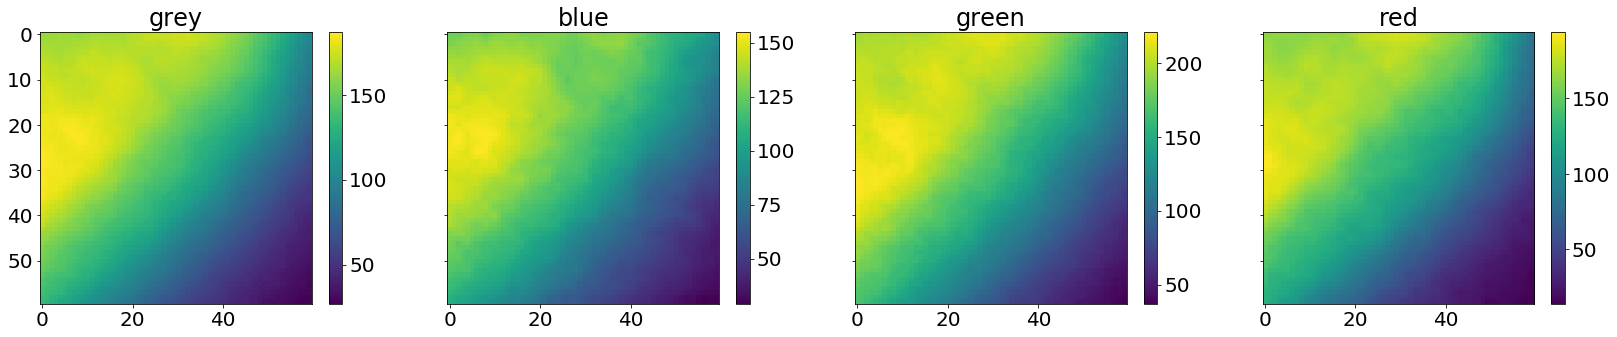

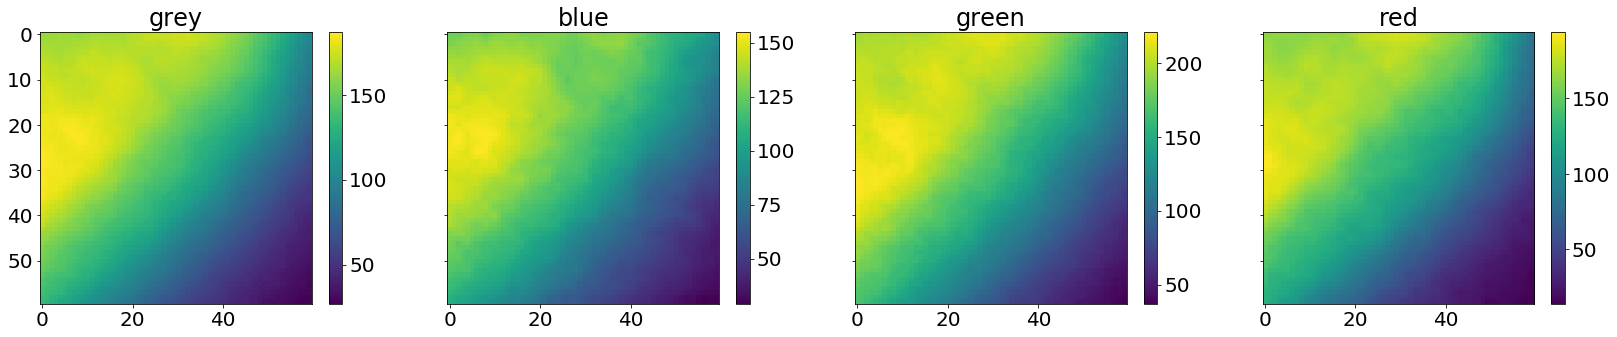

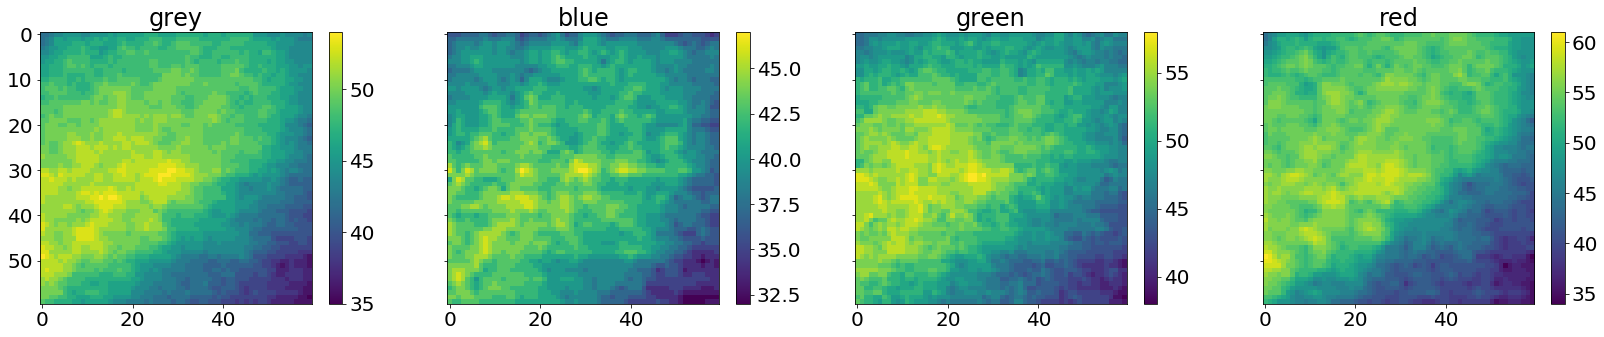

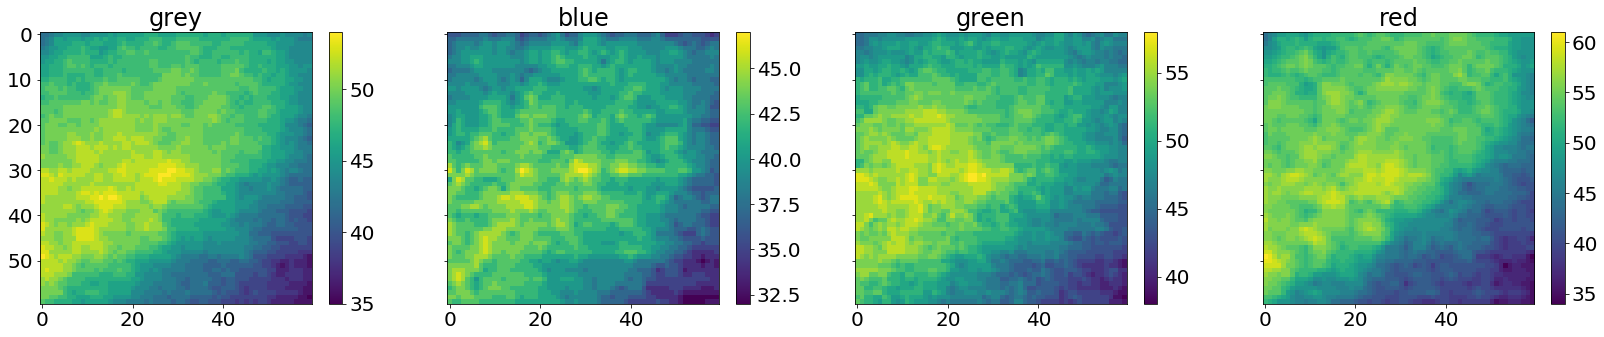

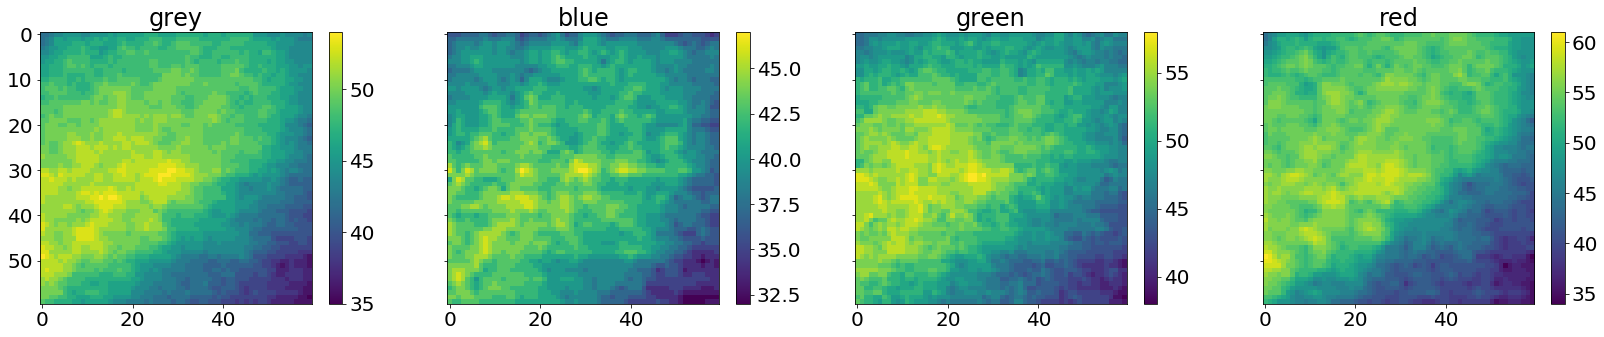

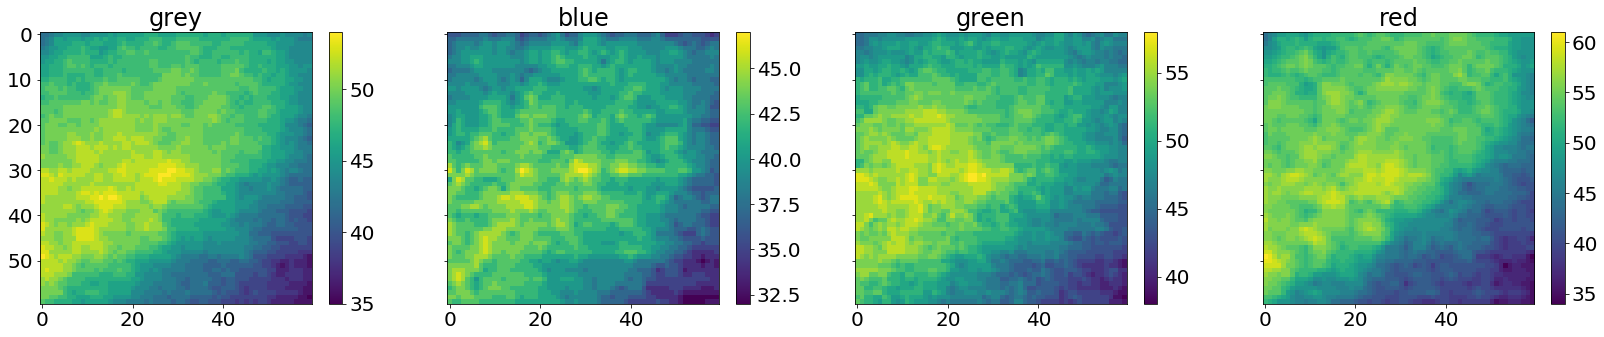

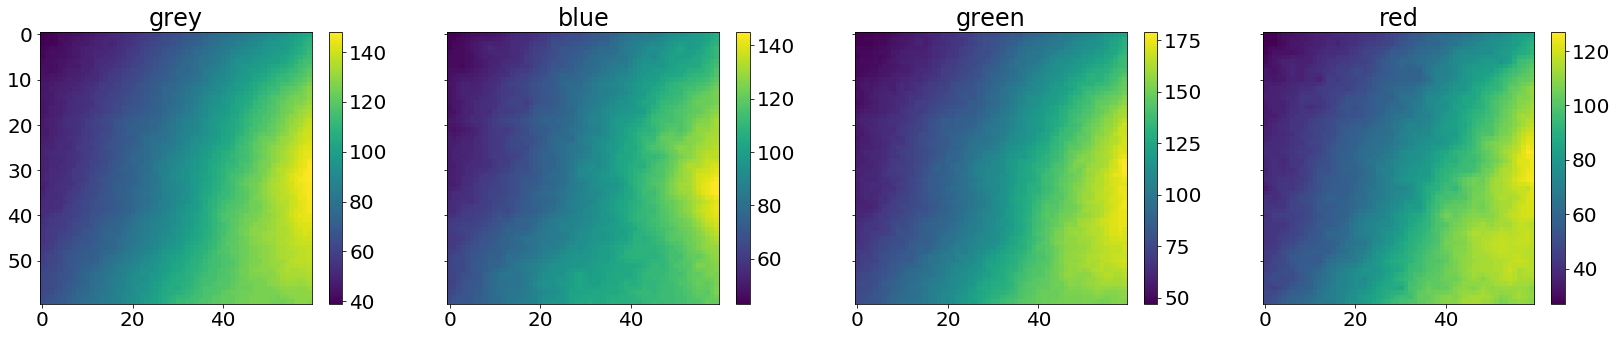

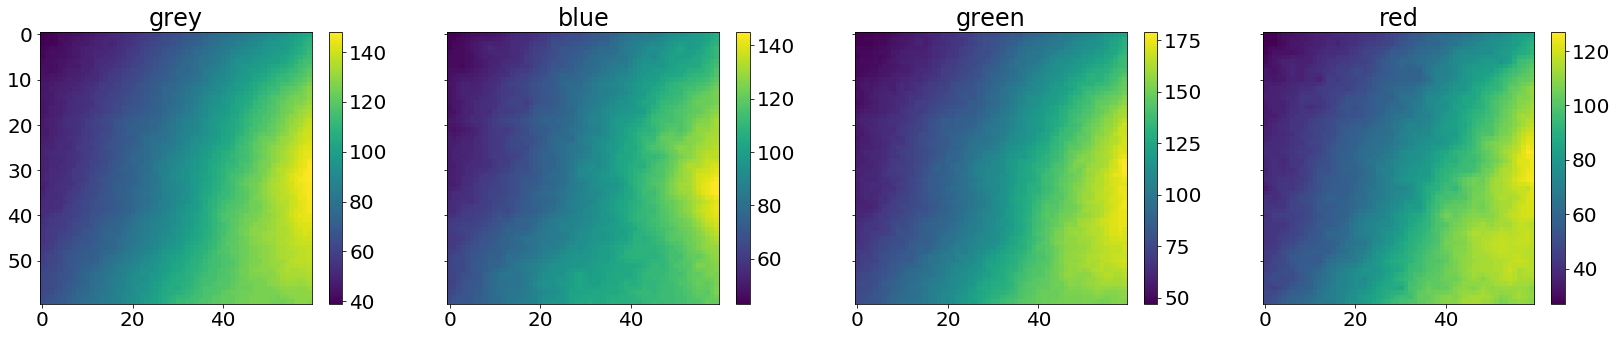

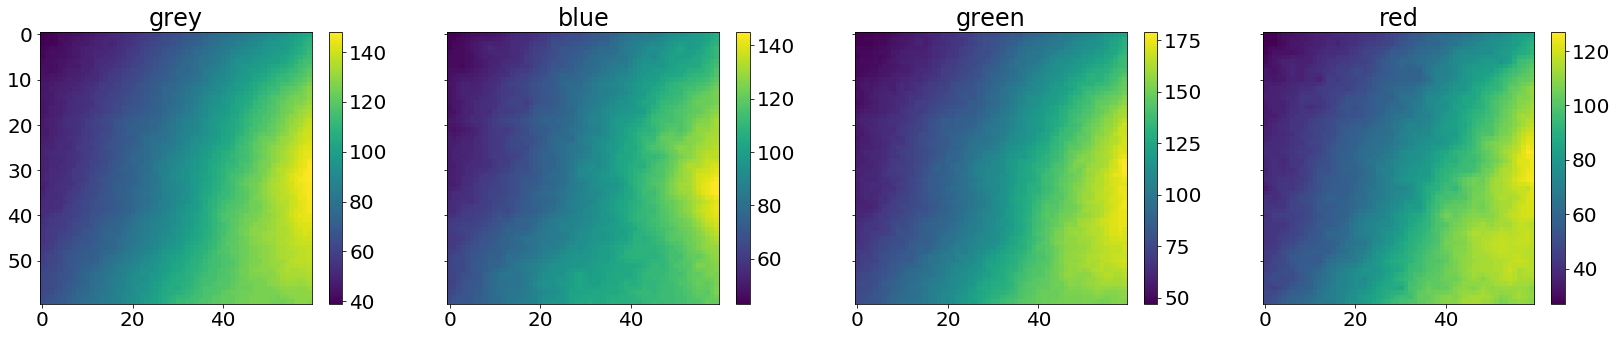

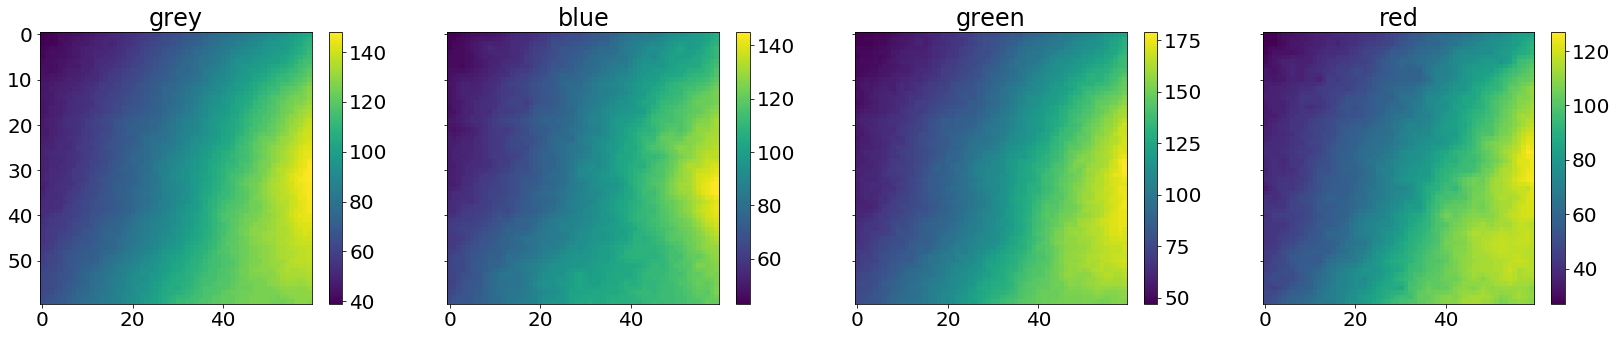

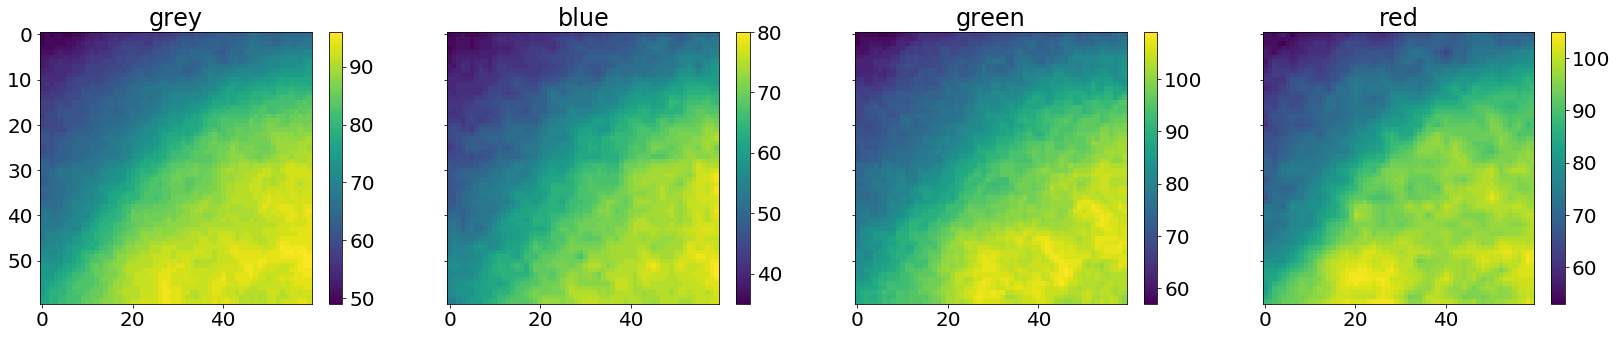

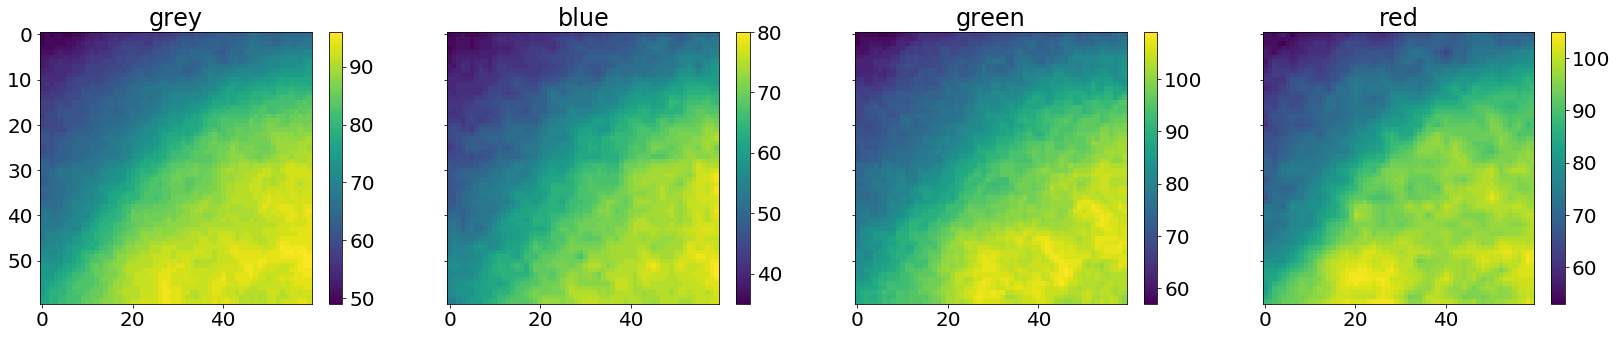

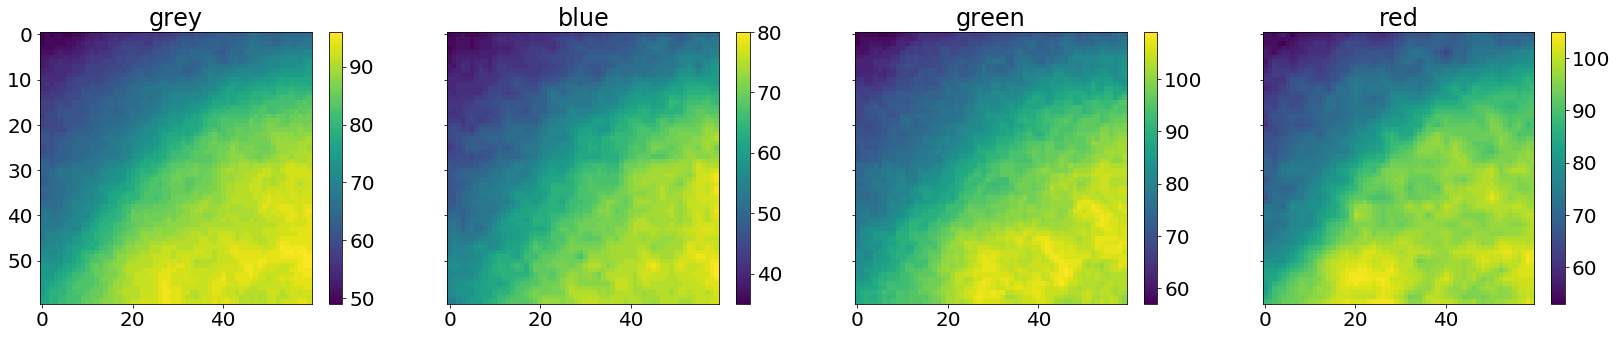

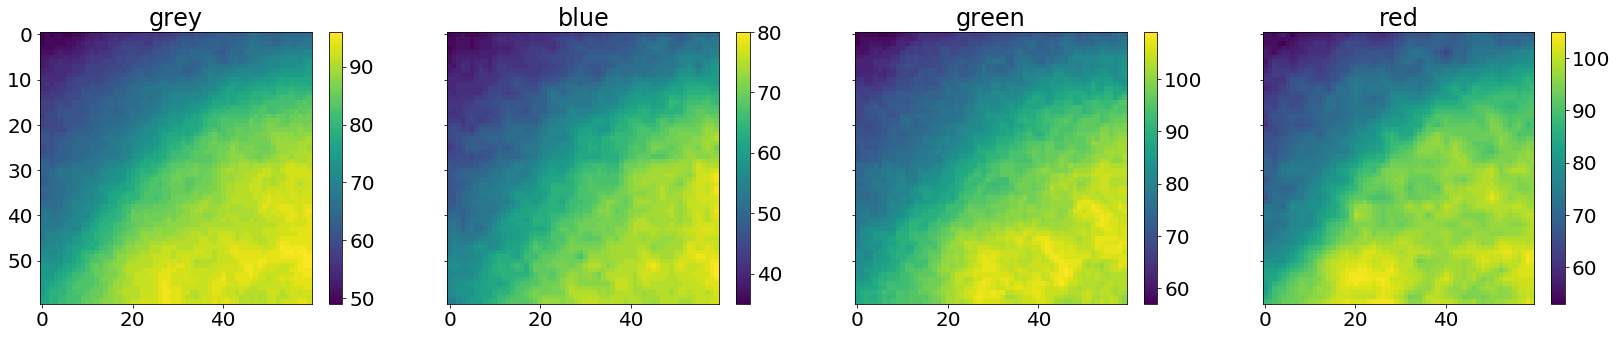

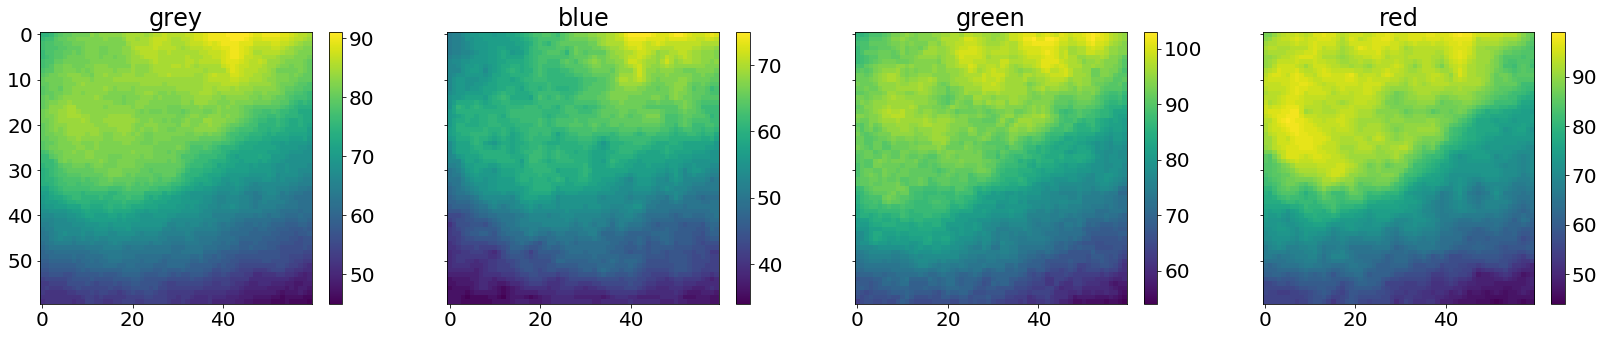

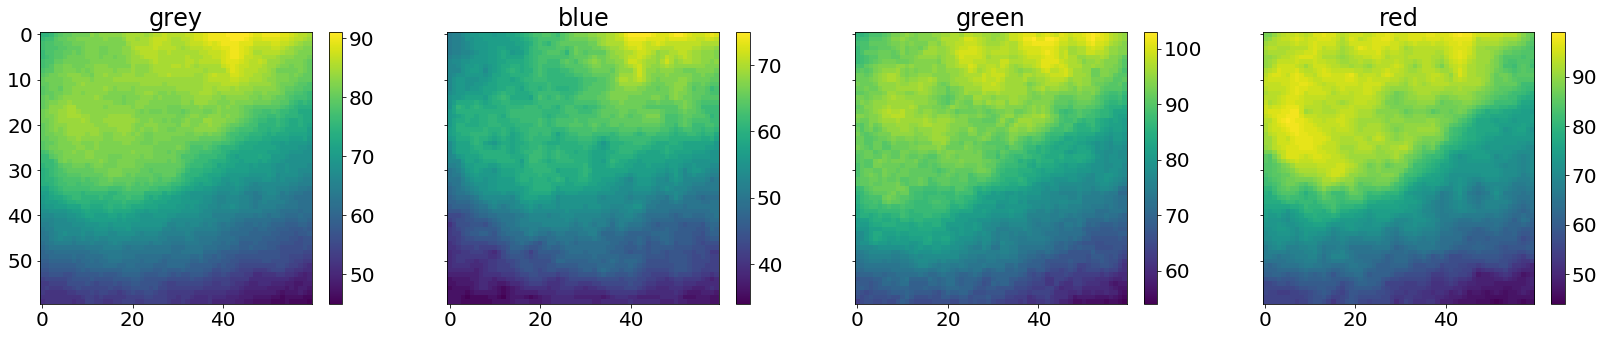

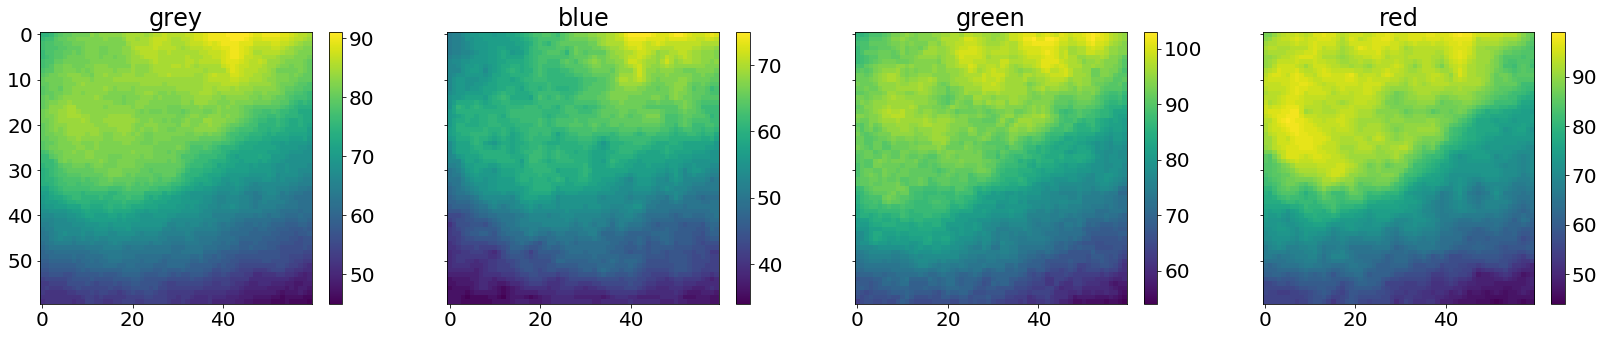

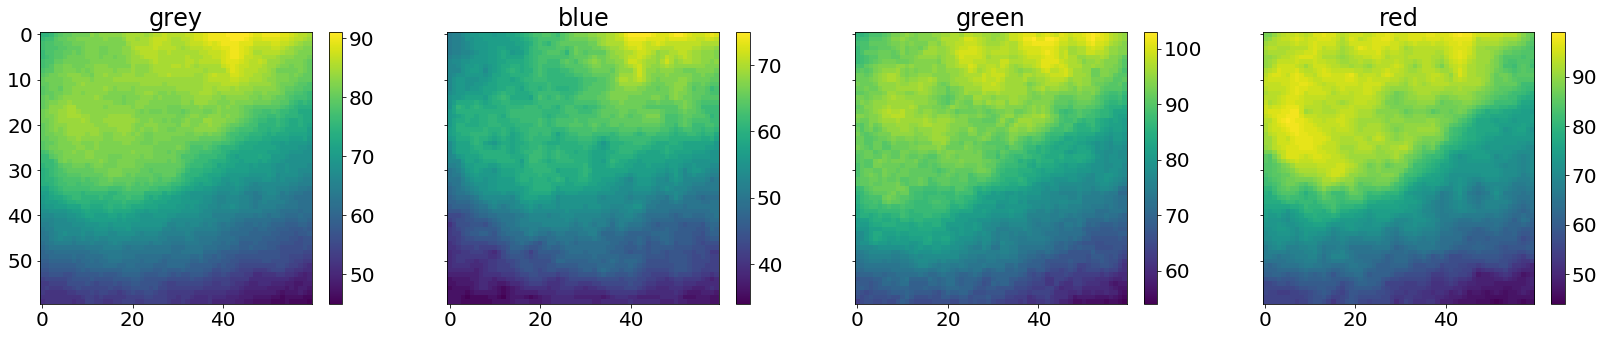

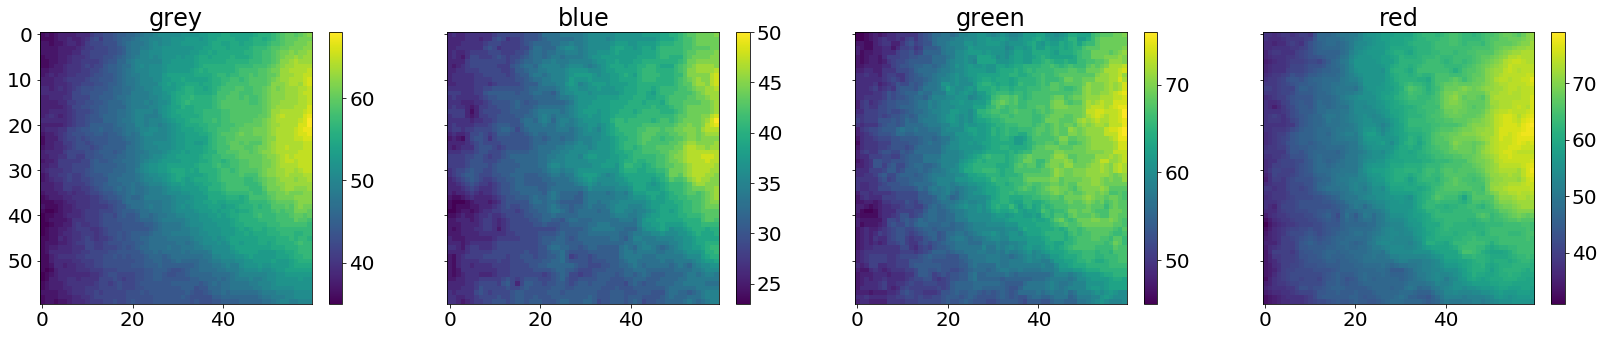

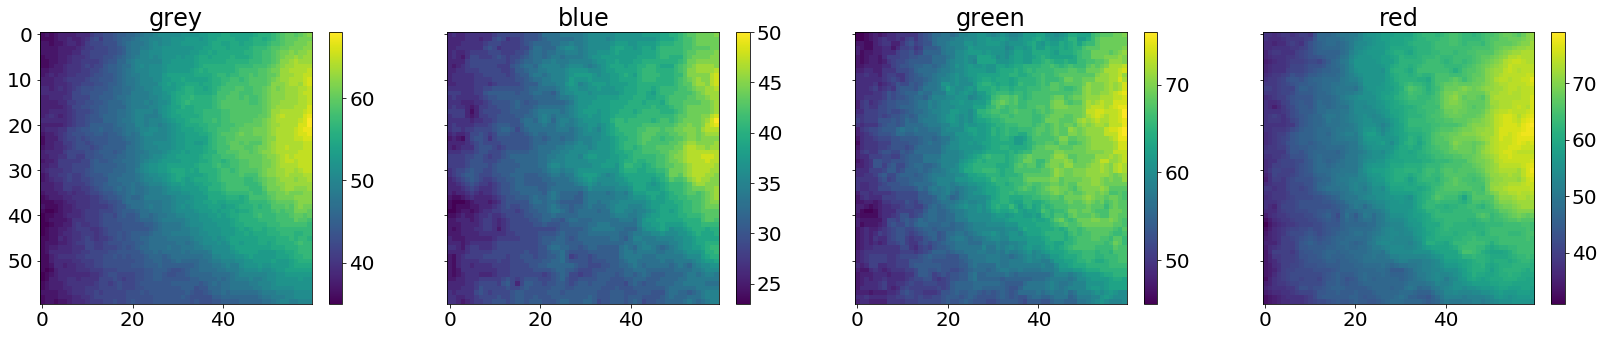

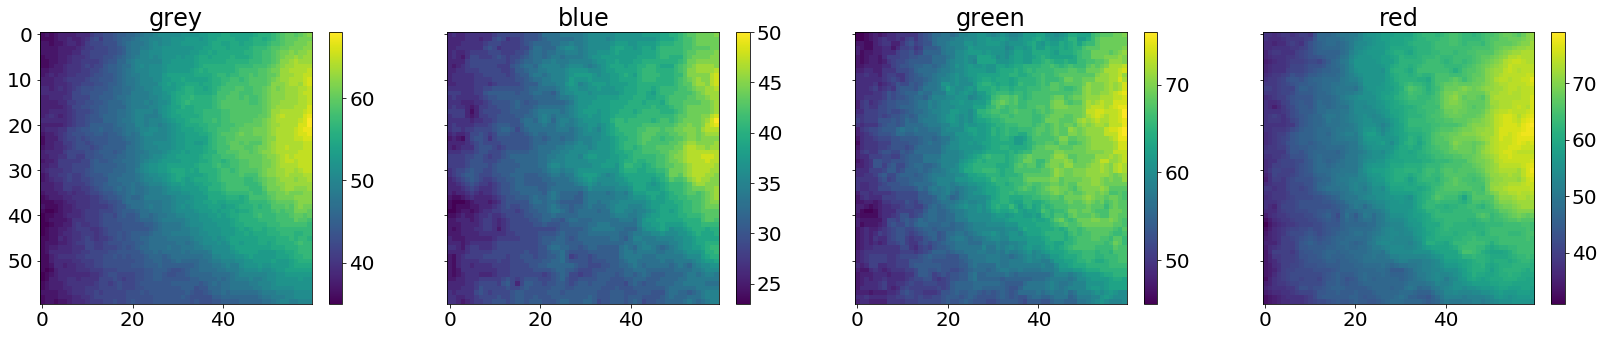

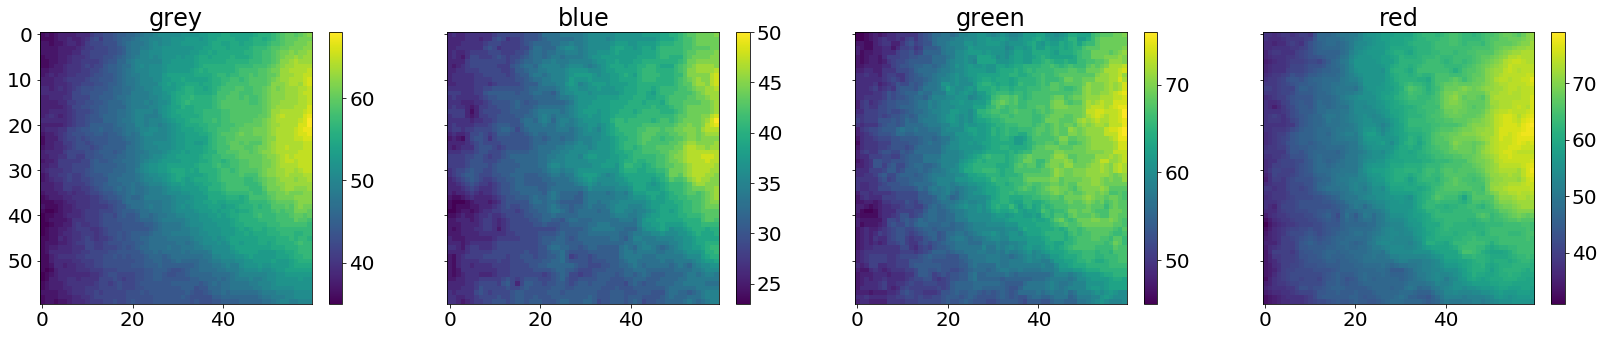

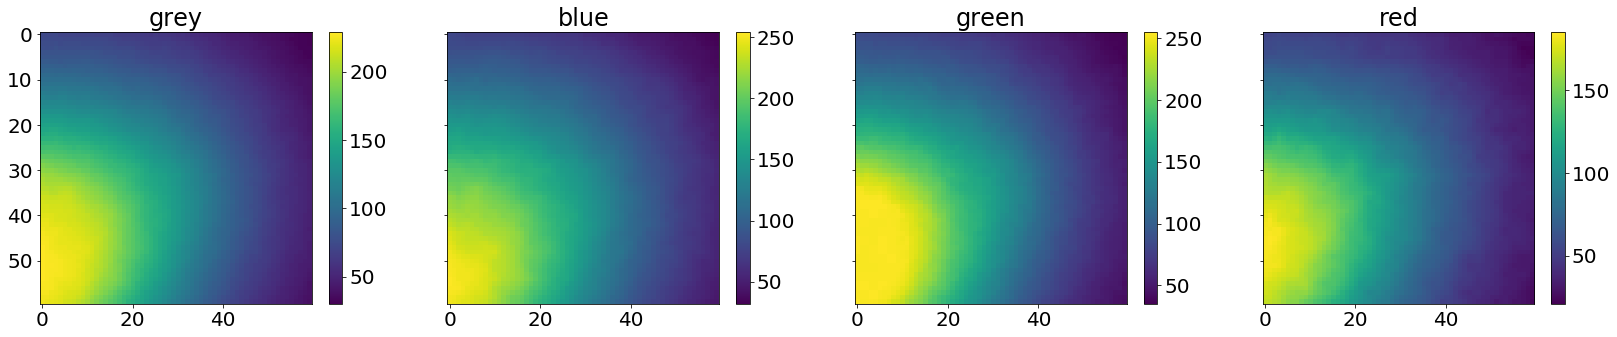

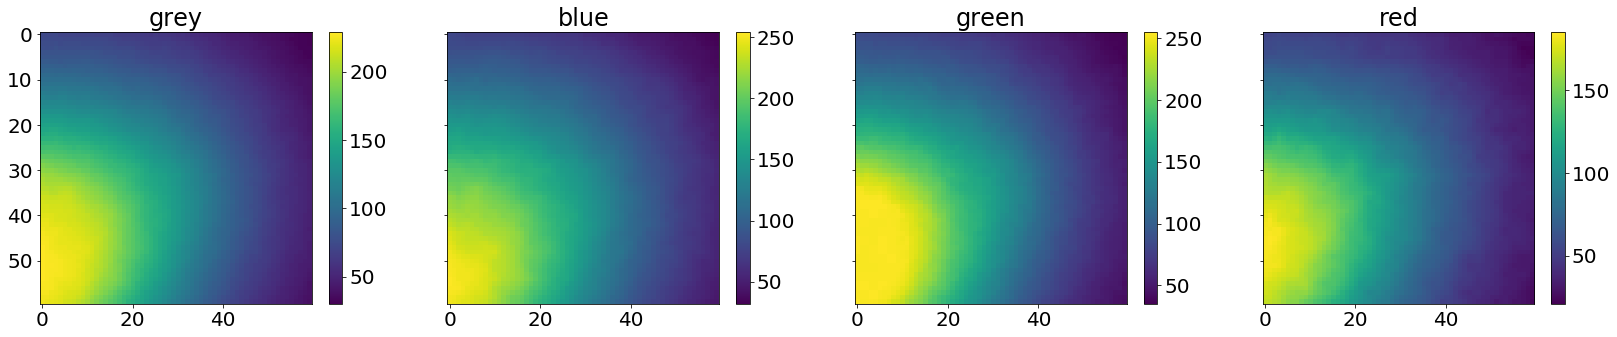

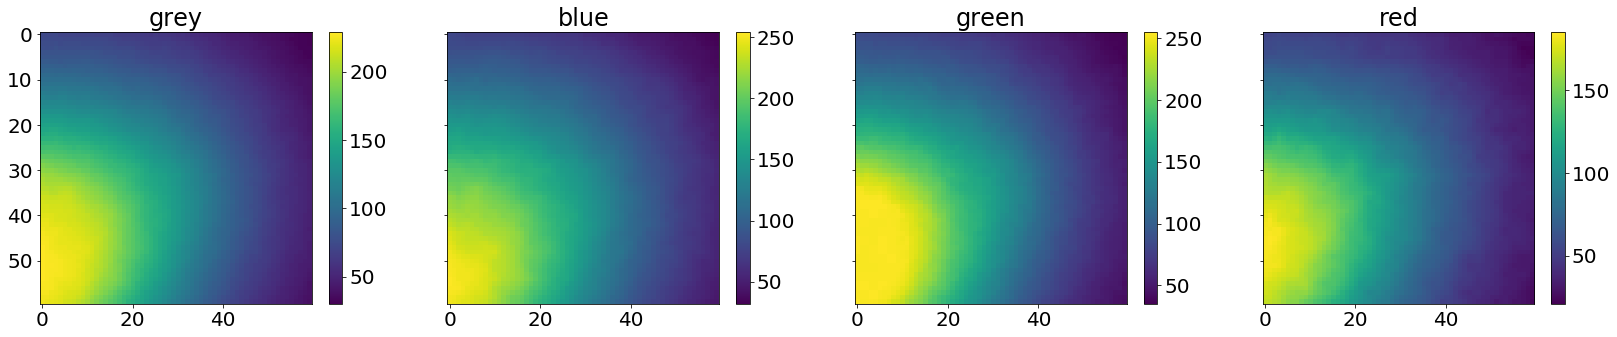

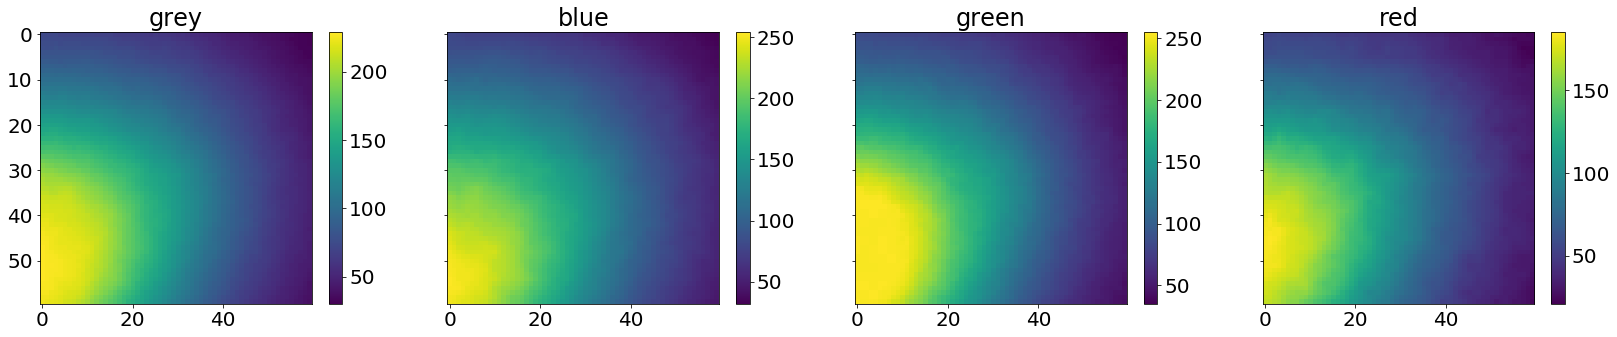

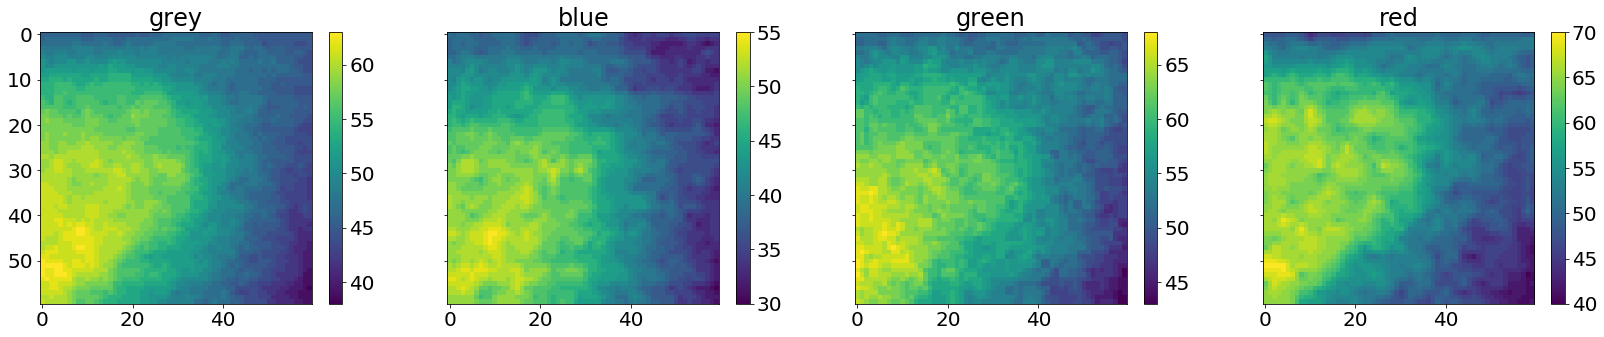

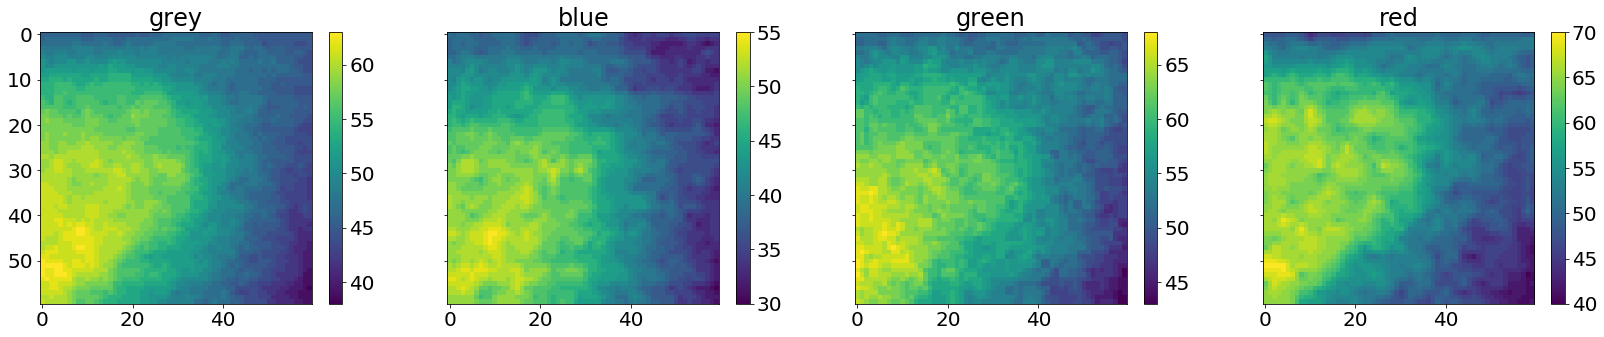

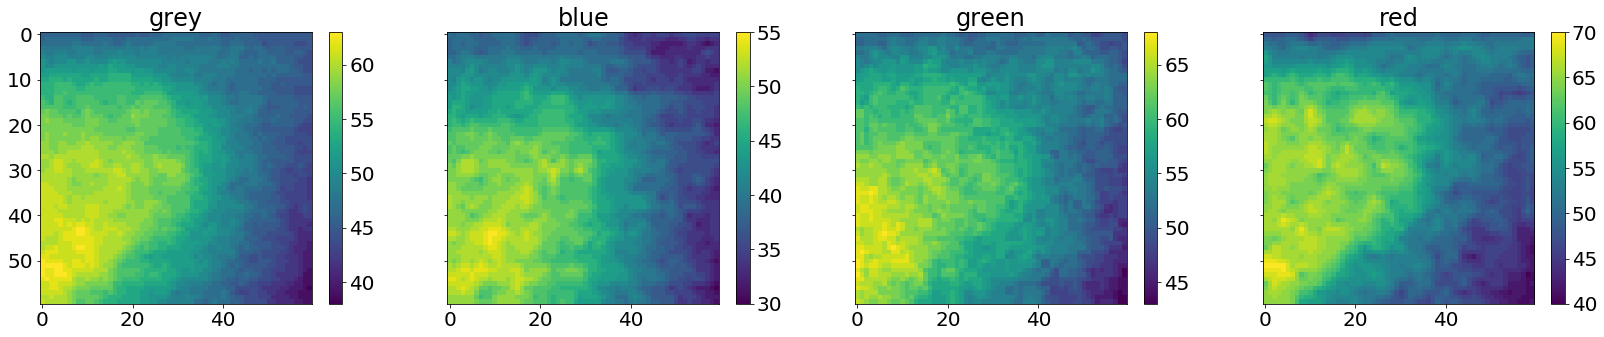

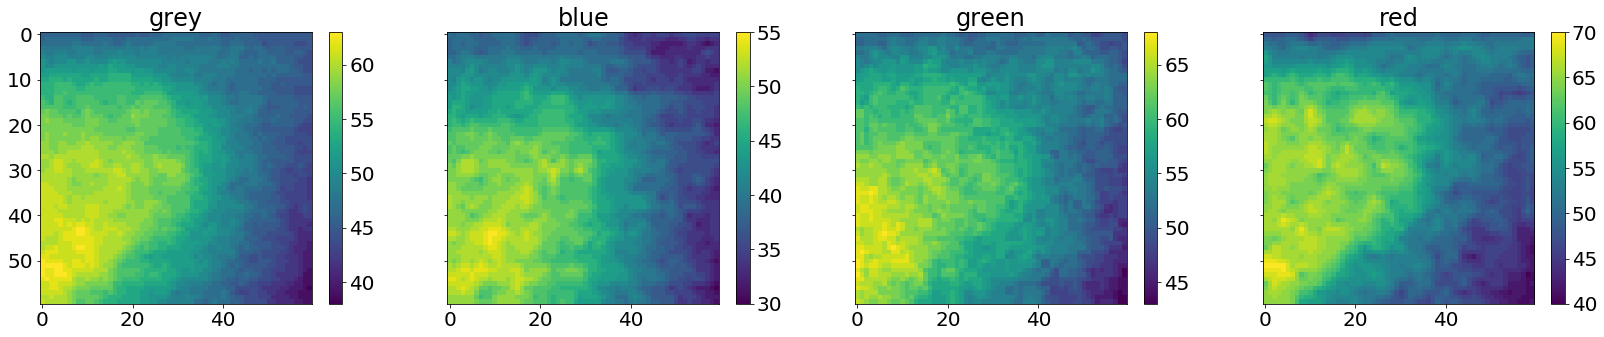

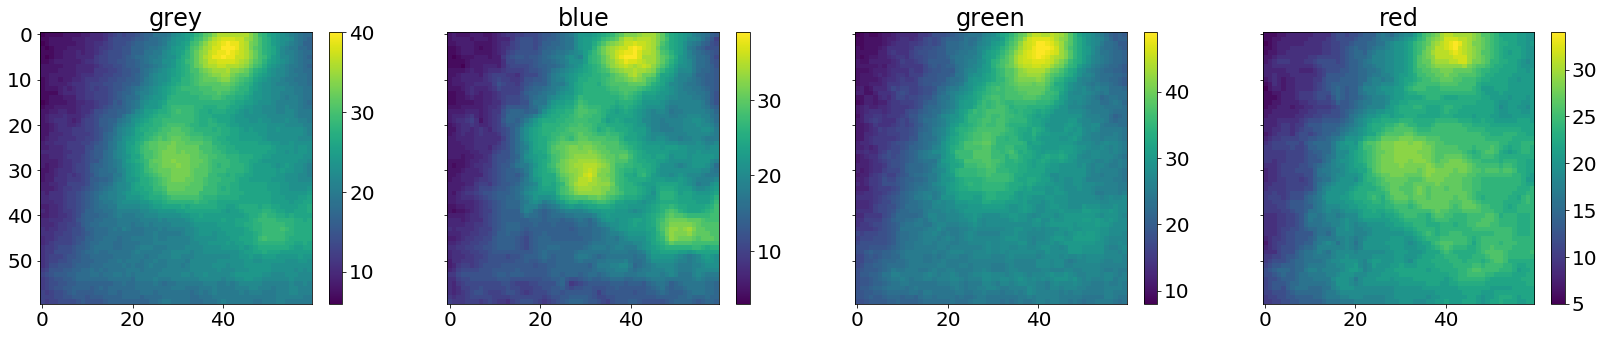

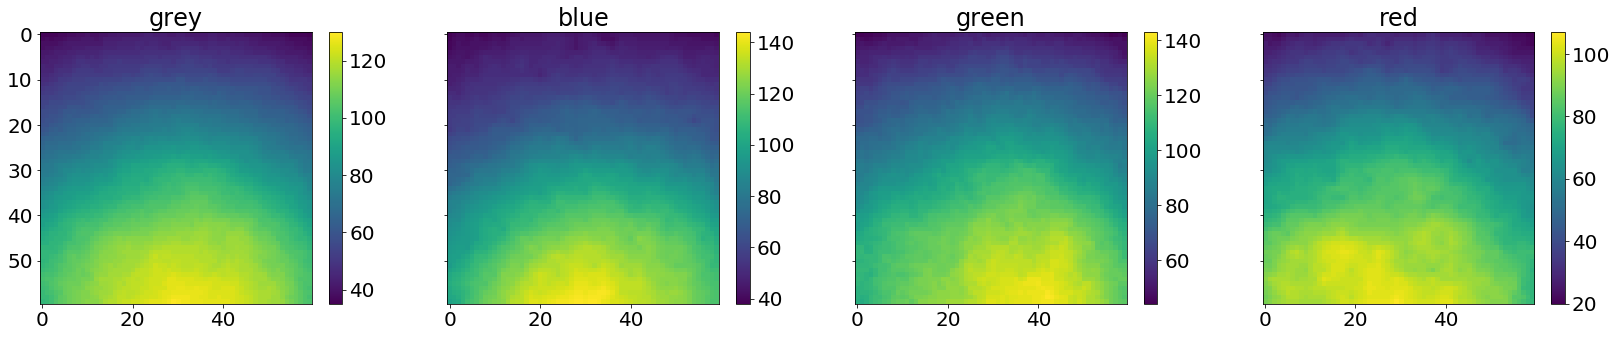

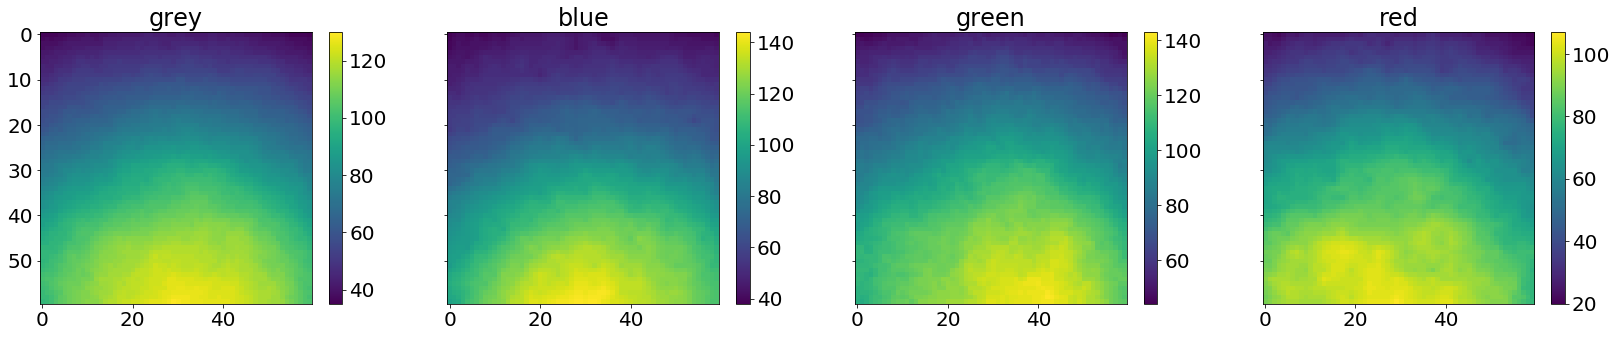

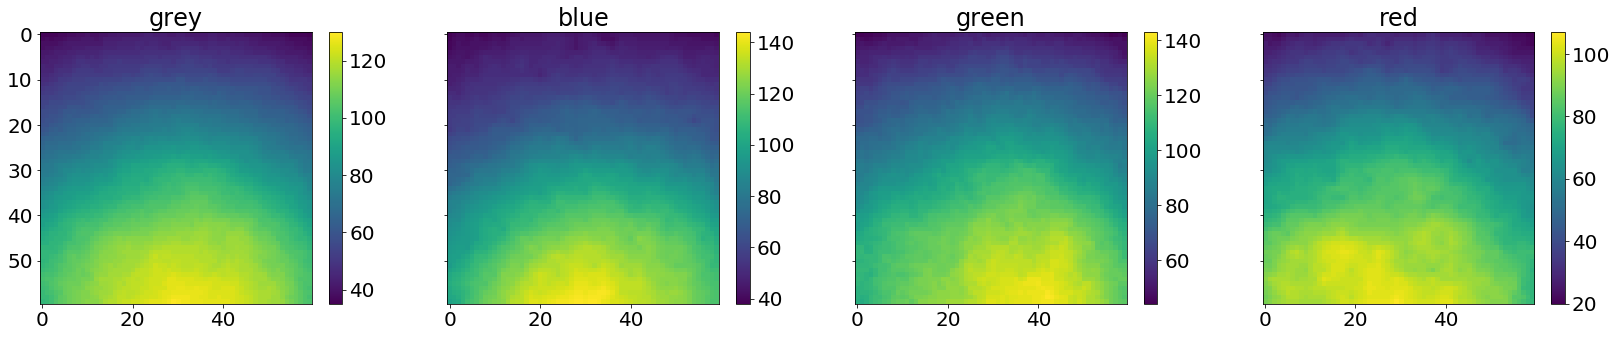

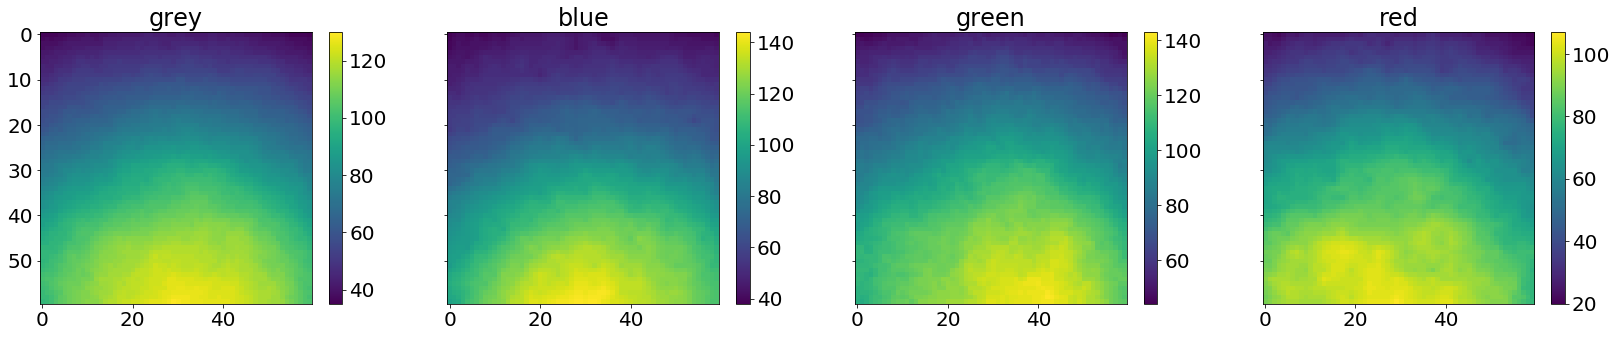

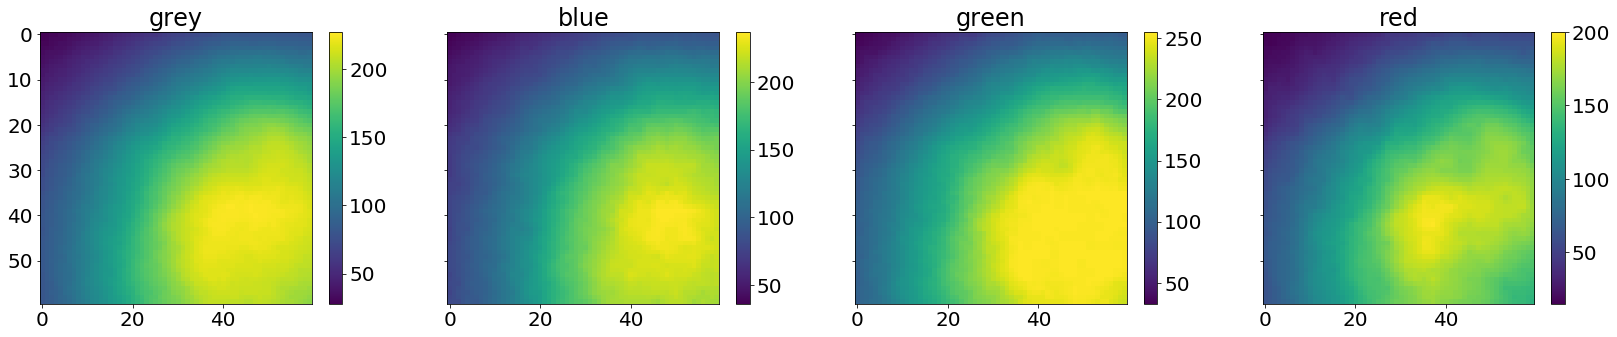

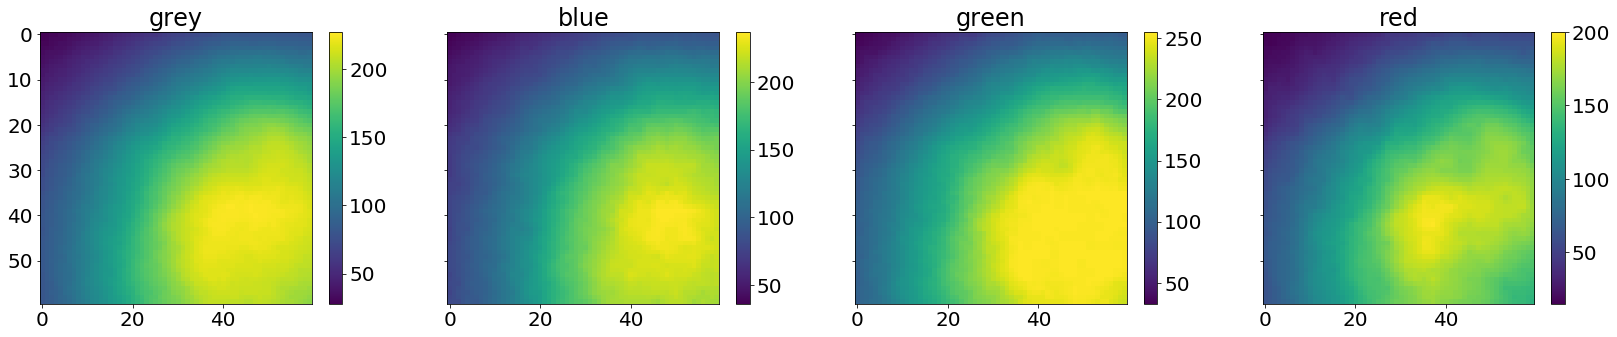

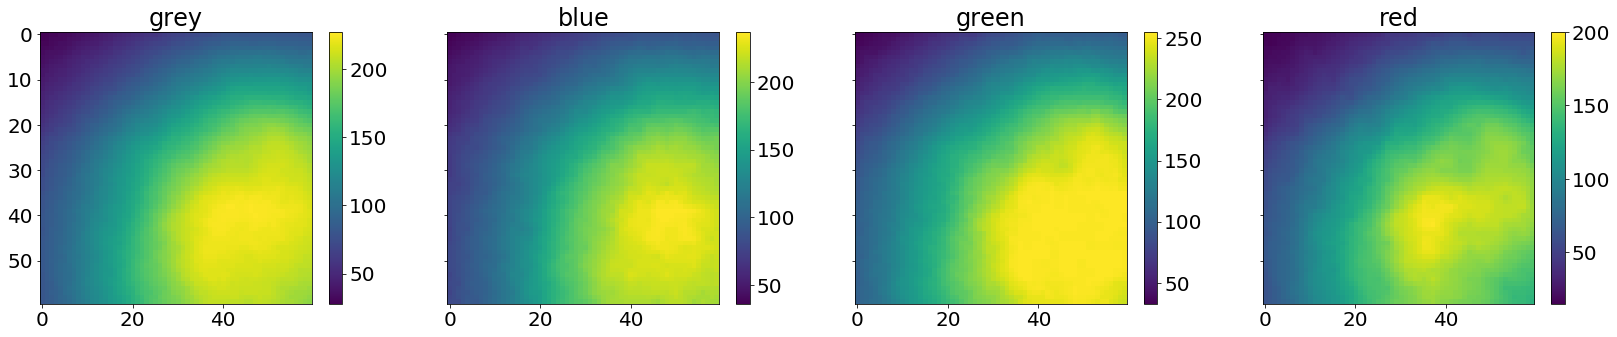

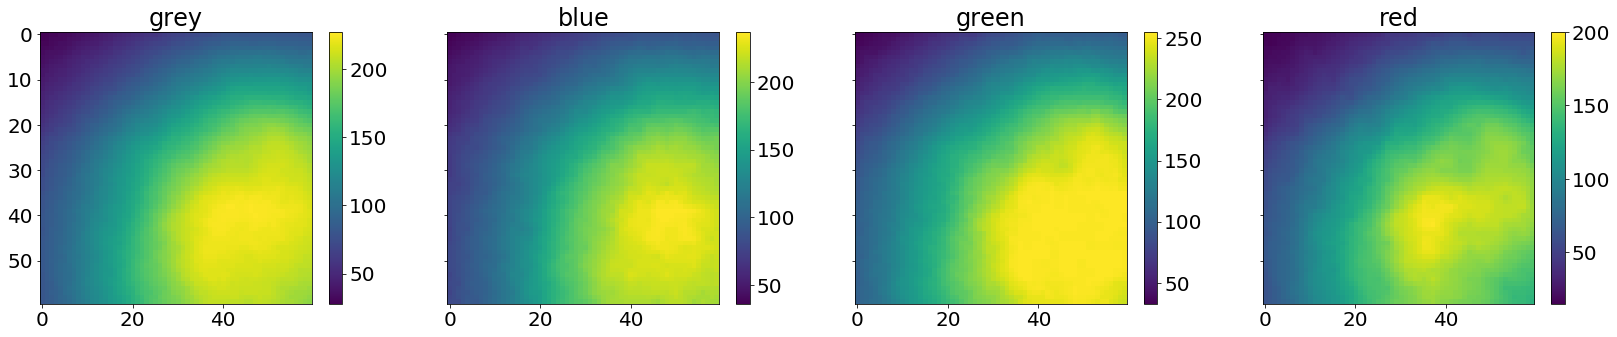

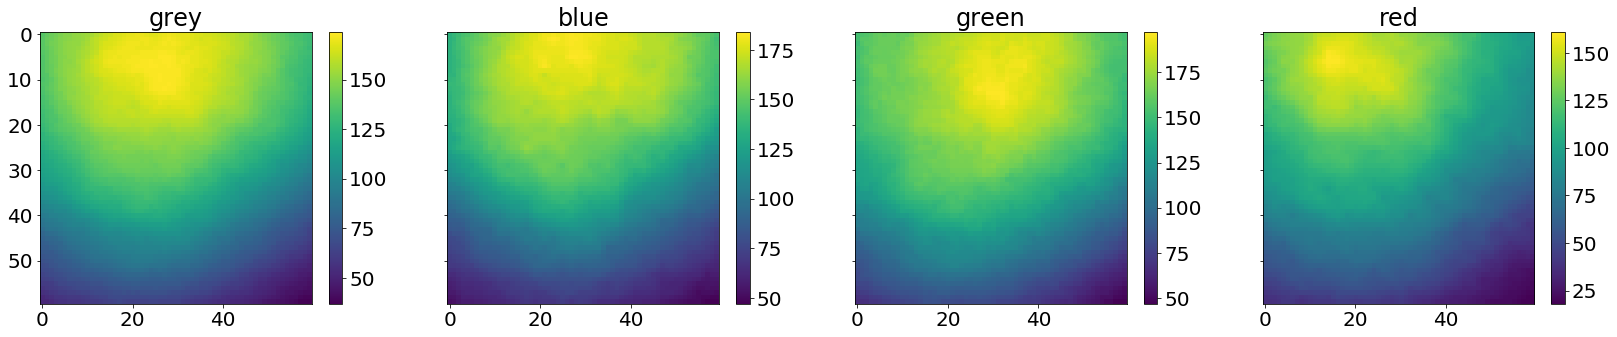

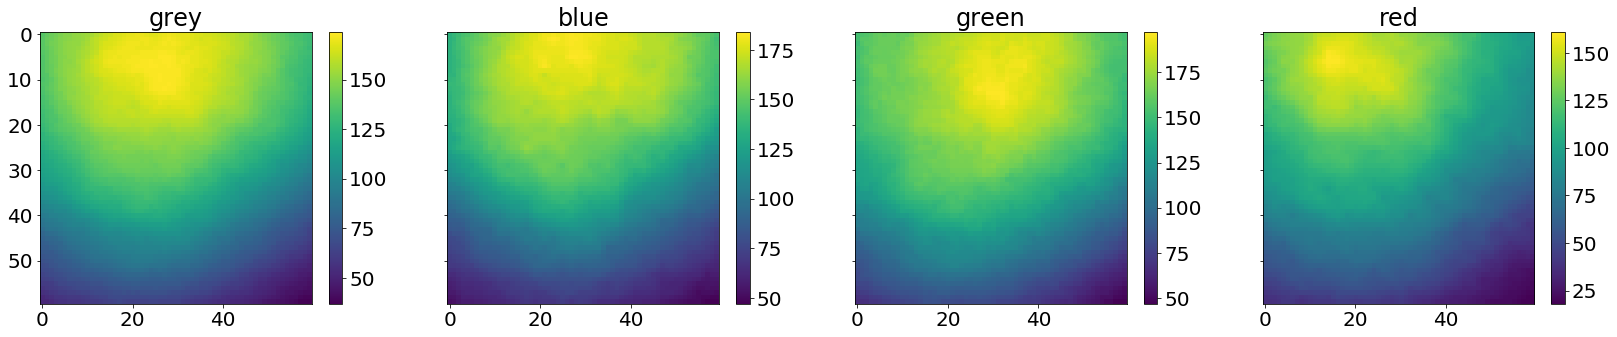

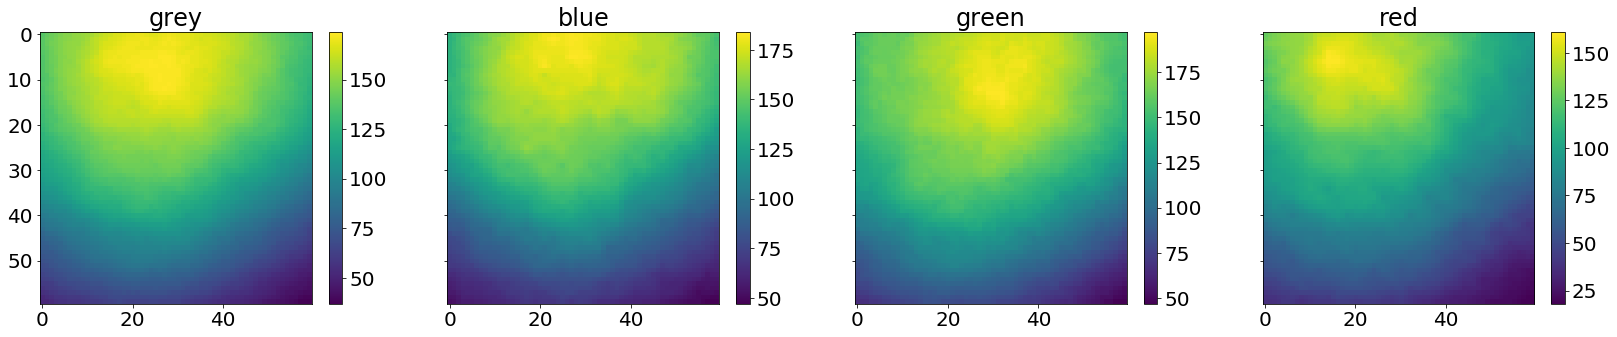

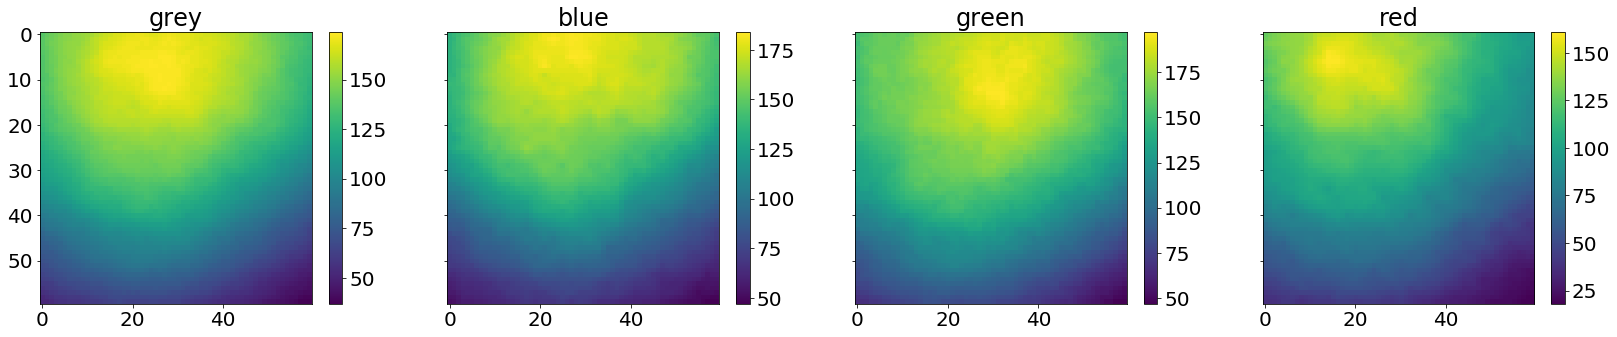

In [8]:
sub_name = {0:'grey', 1:'blue', 2:'green', 3:'red'}
plt.rc('font',size=20)
for i,img in enumerate(tmp_dat[bad_im]):
    fig, axes = plt.subplots(1, 4, figsize=(28, 5), sharey=True)
    for j in range(4):
        im = axes[j].imshow(img[...,j])
        fig.colorbar(im, ax=axes[j])
        axes[j].set_title(sub_name[j])
    plt.show()
    if i>50: break

## Peak wavelength

In [15]:
np.unravel_index(X_tmp[1,...,0].argmax(), X_tmp[1,...,0].shape)

(20, 19)

In [50]:
for i in range(1,4):
    print(X_tmp[1,20,19,i])
peak_bgr = X_tmp[1,20,19,1:]

0.08235294117647059
0.2235294117647059
0.14901960784313725


,Blue,Green,Red
lambda,,,
400,47.5,8.0,13.0
410,69.0,9.5,9.5
420,75.5,11.0,8.0
430,85.0,10.5,6.5
440,93.0,13.0,4.0


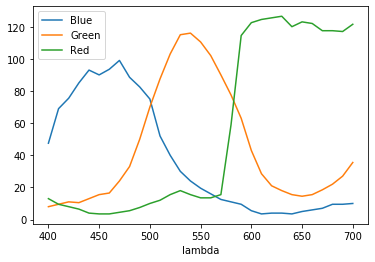

In [30]:
rgb = pd.read_csv('../rgb.csv',sep='\t', index_col='lambda')
rgb = rgb.drop('LED', axis=1)
rgb.plot()
rgb.head()

In [31]:
from scipy.interpolate import interp1d

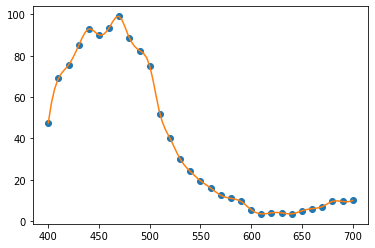

In [37]:
blue_eff = interp1d(rgb.index, rgb['Blue'], kind='cubic')
green_eff = interp1d(rgb.index, rgb['Green'], kind='cubic')
red_eff = interp1d(rgb.index, rgb['Red'], kind='cubic')
x_l = np.linspace(400, 700, 100); y_l = blue_eff(x_l)
plt.plot(rgb.index, rgb['Blue'], 'o', x_l, y_l, '-')

In [43]:
blue_eff(500)

array(75.)

In [48]:
for i, a in enumerate(zip([1],[2],[3])): print(i,a)

0 (1, 2, 3)


In [51]:
lamb_range = np.arange(400, 700)
b_g_eff = blue_eff(lamb_range)/green_eff(lamb_range)
r_g_eff = red_eff(lamb_range)/green_eff(lamb_range)
peak_b_g = peak_bgr[0]/peak_bgr[1]; peak_r_g = peak_bgr[2]/peak_bgr[1]

In [55]:
np.vstack((b_g_eff, r_g_eff)).T.shape

(300, 2)

In [58]:
print(peak_b_g, peak_r_g)

0.3684210526315789 0.6666666666666666


In [65]:
np.argmin(np.sum(((np.vstack((b_g_eff, r_g_eff))-np.array([[peak_b_g, peak_r_g]]).T).T)**2, axis=1))

179

In [71]:
np.argmin(np.sum((np.vstack((b_g_eff-peak_b_g, r_g_eff-peak_r_g)).T)**2, axis=1))

179

In [66]:
np.vstack((b_g_eff, r_g_eff)).T[179]

array([0.14076971, 0.67302787])

In [80]:
def peak_lambda(img, blue_eff, green_eff, red_eff, lamb_range):
    peak_i, peak_j = np.unravel_index(img[...,0].argmax(), img[...,0].shape)
    peak_bgr = [img[peak_i,peak_j,c] for c in [1,2,3]]
    b_g_eff = blue_eff(lamb_range)/green_eff(lamb_range)
    r_g_eff = red_eff(lamb_range)/green_eff(lamb_range)
    peak_b_g = peak_bgr[0]/peak_bgr[1]; peak_r_g = peak_bgr[2]/peak_bgr[1]
    return lamb_range[np.argmin(np.sum((np.vstack((b_g_eff-peak_b_g, r_g_eff-peak_r_g)).T)**2, axis=1))]/1000

In [81]:
peak_lambda(X_tmp[145], blue_eff, green_eff, red_eff, lamb_range)

0.582

# Polar vs Colour dataset

In [10]:
with h5py.File('../../70nm/data/data_ims_scaled_9pol_40.h5','r') as df:
    for name in ['Carbon/100keV', 'Carbon/60keV', 'Carbon/30keV', 'fog']:
        print(name,'\t',df[name+'/images'].shape[0]+df['test/'+name+'/images'].shape[0])

Carbon/100keV 	 232173
Carbon/60keV 	 350830
Carbon/30keV 	 313381
fog 	 168635


In [16]:
for name in ['Carbon-100keV', 'Carbon-60keV', 'Carbon-30keV','fog']:
    with h5py.File('../../70nm/data/ready-to-float/'+name+'.h5','r') as df:
        tmp = df['train/images'].shape[0]+df['val/images'].shape[0]
    with h5py.File('../../70nm/data/data_ims_scaled_9pol_40.h5','r') as df:
        tmp += df['test/'+'/'.join(name.split('-'))+'/images'].shape[0]
    print(name,'\t',tmp)
name = 'fog'

    #    print(name,'\t',df[name+'/images'].shape[0]+df['test/'+name+'/images'].shape[0])

Carbon-100keV 	 135813
Carbon-60keV 	 173157
Carbon-30keV 	 160310
fog 	 149473


In [11]:
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    for name in ['Carbon/100keV', 'Carbon/60keV', 'Carbon/30keV', 'fog']:
        print(name,'\t',df[name+'/images'].shape[0]+df['test/'+name+'/images'].shape[0])

Carbon/100keV 	 109386
Carbon/60keV 	 123701
Carbon/30keV 	 79657
fog 	 77820


In [34]:
with h5py.File('data_ready_4.h5','r') as df:
    print(np.unique(df['train/labels'], return_counts=True))
    print(np.unique(df['val/labels'], return_counts=True))

(array([0., 1., 2., 3.]), array([28000, 28000, 28000, 42000]))
(array([0., 1., 2., 3.]), array([ 6800,  6800,  6800, 10200]))


In [35]:
with h5py.File('data_scale_ims_col_40.h5','r') as df:
    for name in ['Carbon/100keV', 'Carbon/60keV', 'Carbon/30keV', 'fog']:
        print(name,'\t',df['test/'+name+'/images'].shape[0])

Carbon/100keV 	 27154
Carbon/60keV 	 45931
Carbon/30keV 	 28787
fog 	 24411
